In [1]:
# Compile all the code for the paper 'Decreased UHI under warmer conditions'
# do only the period 2006-2016
# import libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import ulmo
import os
import scipy.stats
import matplotlib
import cartopy.crs as ccrs
import time
import cartopy.io.shapereader as shpreader
matplotlib.rcParams.update({'font.size': 18})

In [2]:
#import cartopy
print(np.__version__, pd.__version__, ulmo.__version__, scipy.__version__,
      matplotlib.__version__,) #cartopy.__version__)
import sys
print(sys.version)
#### Usage notes: in Python2, my 'homemade' stats tests run into numerical errors. 
#### For backcompatibility in Python2, 

1.11.1 0.19.1 0.8.3dev 0.18.1 1.5.1
3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:52:12) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]


In [3]:
results_filename = 'US_results_cleaned_data.csv'
results_filepath = 'plots/version6/'

In [43]:
# functions
def prettify_plot(): 
    ""'Hides top and rightmos axis spines and also some other stuff. '""
    figures = [x for x in matplotlib._pylab_helpers.Gcf.get_all_fig_managers()]
    for figure in figures:
        # Get all Axis instances related to the figure.
        for ax in figure.canvas.figure.get_axes():
            # Disable spines.
            ax.spines['right'].set_color('none')
            ax.spines['top'].set_color('none')
            # Disable ticks.
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
    
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.set_axis_bgcolor('none')
    plt.grid(b=False, which='major')
    
def color_scatter_years(x,y,title, xlabel, ylabel): 
    fig, ax = plt.subplots()
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    cmap = plt.cm.get_cmap('Greys_r', 7)
    cax = ax.scatter(x[ind],y[ind], c = x[ind].index, cmap = cmap)# cmap = plt.cm.bone)
    #plt.scatter(x[ind],y[ind], c = x[ind].index, cmap = plt.cm.bone)
    cbar = fig.colorbar(cax, ticks=[1985,1995, 2005, 2015], orientation='horizontal')
    #plt.colorbar()
    cbar.ax.set_xticklabels(['1985','1995', '2005', '2015'])  # horizontal colorbar
    ax.plot(x, m*x+b, color = 'black')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    ax.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('r = %.2f'%(r), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('p = %.2f'%(p), xy=(.5, .7), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('N = %i'%(ind.shape), xy=(.5, .6), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m,r,p
def color_scatter(x,y,title, xlabel, ylabel): 
    fig, ax = plt.subplots()
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    cax = ax.scatter(x[ind],y[ind], c = x[ind].index, cmap = plt.cm.bone)
    #plt.scatter(x[ind],y[ind], c = x[ind].index, cmap = plt.cm.bone)
    cbar = fig.colorbar(cax, ticks=[6000,16800], orientation='horizontal')
    #plt.colorbar()
    cbar.ax.set_xticklabels(['1985', '2016'])  # horizontal colorbar
    ax.plot(x, m*x+b, color = 'black')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    ax.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('r = %.2f'%(r), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('N = %i'%(ind.shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m,r,p

# plotting 
# define functions used for plotting 
def lin_trend_plot(start_x, y,title, xlabel, ylabel) : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y.values)# & ~np.isnan(x) # subset values that aren't NaNs
    x = np.arange(0,y.shape[0])
    m, b, r_value, p, std_err = scipy.stats.linregress(x[ind],y[ind])
    plt.scatter(x+start_x,y)
    plt.plot(x+start_x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r = %.2f'%(r_value), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('N = %i'%(ind.shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, b, r_value, p, std_err

import scipy.stats
import scipy.stats.distributions as distributions
import random
import math
import collections
def linregress_mod(x, y= None, null_slope = 0) : 
    # modification of scipy.stats, using Adam Kurkiewicz's code from
    # https://github.com/scipy/scipy/issues/7074
    """
    Calculate a regression line
    This computes a least-squares regression for two sets of measurements.
    Parameters
    ----------
    x, y : array_like
        two sets of measurements.  Both arrays should have the same length.
        If only x is given (and y=None), then it must be a two-dimensional
        array where one dimension has length 2.  The two sets of measurements
        are then found by splitting the array along the length-2 dimension.
    Returns
    -------
    slope : float
        slope of the regression line
    intercept : float
        intercept of the regression line
    r-value : float
        correlation coefficient
    p-value : float
        two-sided p-value for a hypothesis test whose null hypothesis is
        that the slope is zero.
    stderr : float
        Standard error of the estimate

    """
    TINY = 1.0e-20
    if y is None:  # x is a (2, N) or (N, 2) shaped array_like
        x = np.asarray(x)
        if x.shape[0] == 2:
            x, y = x
        elif x.shape[1] == 2:
            x, y = x.T
        else:
            msg = "If only `x` is given as input, it has to be of shape (2, N) \
            or (N, 2), provided shape was %s" % str(x.shape)
            raise ValueError(msg)
    else:
        x = np.asarray(x)
        y = np.asarray(y)
    n = len(x)
    xmean = np.mean(x,None)
    ymean = np.mean(y,None)

    # average sum of squares:
    ssxm, ssxym, ssyxm, ssym = np.cov(x, y, bias=1).flat
    r_num = ssxym
    r_den = np.sqrt(ssxm*ssym)
    if r_den == 0.0:
        r = 0.0
    else:
        r = r_num / r_den
        # test for numerical error propagation
        if (r > 1.0):
            r = 1.0
        elif (r < -1.0):
            r = -1.0

    df = n-2
    t = r*np.sqrt(df/((1.0-r+TINY)*(1.0+r+TINY)))
    prob = distributions.t.sf(np.abs(t),df)*2
    slope = r_num / ssxm
    intercept = ymean - slope*xmean
    sterrest = np.sqrt((1-r*r)*ssym / ssxm / df)
    
    
    rr = lambda x: intercept + slope*x

#     # Partial steps to compute Wald Statistic.
#     # as in https://github.com/scipy/scipy/issues/7074, from Feb 2017
#     # attribution: https://github.com/picrin
#     # Adam Kurkiewicz, http://cv.adam.kurkiewicz.pl/
#     XDiff = [X_i - xmean for X_i in x]
#     XDiffSquared = [i*i for i in XDiff]
#     YDiff = [Y_i - ymean for Y_i in y]
    
#     errs = [yy - rr(xx) for xx, yy in zip(x, y)]
#     errStd = math.sqrt((1/(n-2))*(sum([err**2 for err in errs])))
#     XStd = math.sqrt((1/(n))*sum([diff**2 for diff in XDiff]))
#     stdB1 = errStd / (XStd * math.sqrt(n))

#     # Wald Statistic.
#     W = (slope - null_slope)/stdB1
#     # pvalue of Wald Test of B1 = 0.
#     pvalueWald = 2*scipy.stats.norm.cdf(-abs(W))
#     # pvalue of T test of B1 = 0.
#     pvalueT = 2*distributions.t.sf(abs(W), n - 2)
    pvalueWald = np.nan
    pvalueT = np.nan
    return slope, intercept, r, prob, sterrest, pvalueWald, pvalueT

def easy_scatter(x,y,title='', xlabel='', ylabel='', text_y_loc = .9 ) : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    #m,b = np.polyfit(x[ind],y[ind],1)
    #r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    #m, b, r, p, sterrest, pvalueWald, pvalueT =  linregress_mod(x[ind], y[ind], null_slope = 1)
    m, b, r, p, sterrest  =  scipy.stats.linregress(x[ind], y[ind])
    plt.scatter(x[ind],y[ind], color = 'grey')
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, text_y_loc), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r = %.2f'%(r), xy=(.5, text_y_loc-.05), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p = %.2f'%(p), xy=(.5, text_y_loc-.1), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('N = %i'%(ind.shape), xy=(.5, text_y_loc -.15), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, r, p

def easy_scatter_wald(x,y,title='', xlabel='', ylabel='') : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    #m,b = np.polyfit(x[ind],y[ind],1)
    #r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    m, b, r, p, sterrest, pvalueWald, pvalueT =  linregress_mod(x[ind], y[ind], null_slope = 1)
    plt.scatter(x[ind],y[ind], color = 'grey')
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r = %.2f'%(r), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p = %.2f'%(pvalueWald), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('N = %i'%(ind.shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, b, r, p, pvalueWald, pvalueT#m, r, p

def map_hist_plot(data, paired_df, title = 'Response of $\Delta T$ to Temperature Change', data_label = 'm$_{JJA}$ ($^\circ$C$ / ^\circ $C)', label_city = False, c_insignificant = np.array([]),  bounds = np.linspace(0,2,11)) : 
    # plots a map and histogram of data, a pandas dataframe with cities in the index 
    # paired_df 
    # results_df[results_df['P-value']>0.05]
    fig = plt.figure(figsize=[15,7])
    ax = plt.axes([0, 0, 1, 1],
                       projection=ccrs.LambertConformal())
    ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
    ax.set_title(title)
    # download default shapefils from natura_earth using cartopy's shapereader
    shapename = 'admin_1_states_provinces_lakes_shp'
    states_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)

    # to get the effect of having just the states without a map "background"
    # turn off the outline and background patches
    ax.background_patch.set_visible(False)
    ax.outline_patch.set_visible(False)

    # Plot background state map
    for state in shpreader.Reader(states_shp).geometries():
        # pick a default color for the land with a black outline,
        # this will change if the storm intersects with our track
        facecolor = 'None'#[0.9375, 0.9375, 0.859375]
        edgecolor = 'black'
        ax.add_geometries([state], ccrs.PlateCarree(),
                          facecolor=facecolor, edgecolor=edgecolor, zorder = 0)

    # define data
    data = data[~np.isnan(data)]
    # Set up colors for plotting
    cmap = matplotlib.cm.coolwarm
    c = data
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    marker_size = 150

    # plot data

    ax.set_title('a) ')
    # plot significance
    #c_insignificant = results_df[results_df['P-value']>0.05]
    if c_insignificant.shape[0] > 0 : 
        ax.scatter(paired_df.set_index('City').loc[c_insignificant.index]['Urban Lon'], paired_df.set_index('City').loc[c_insignificant.index]['Urban Lat'], 
                #paired_df['Urban Lon'].iloc[insig_inds], paired_df['Urban Lat'].iloc[insig_inds], 
                    c = c[c_insignificant.index].values, s = marker_size-50, 
                   transform=ccrs.Geodetic(),edgecolors= 'None',
                   cmap = cmap, norm = norm, zorder =1)        
        sig_cities = np.setdiff1d(paired_df.index,c_insignificant.index )
        plotHandle = ax.scatter(paired_df.set_index('City').loc[sig_cities]['Urban Lon'], 
                                paired_df.set_index('City').loc[sig_cities]['Urban Lat'], 
                            c = c[sig_cities].values, s = marker_size, alpha = 1, 
                            transform=ccrs.Geodetic(), edgecolors = 'darkgray', 
                     cmap = cmap,
                     norm = norm, zorder = 1, )
    else: 
        plotHandle = ax.scatter(paired_df.set_index('City').loc[c.index]['Urban Lon'], paired_df.set_index('City').loc[c.index]['Urban Lat'], 
                        c = c.values, s = marker_size, alpha = 1, 
                        transform=ccrs.Geodetic(), edgecolors = 'darkgray', 
                 cmap = cmap,
                 norm = norm, zorder = 1, )

    if label_city == True: 
        for city, lon, lat in zip(c.index, paired_df.set_index('City').loc[c.index]['Urban Lon'].values, paired_df.set_index('City').loc[c.index]['Urban Lat'].values): 
            if city != 'Honolulu': 
                ax.text(lon+.5,lat, city,
                        #xy = (paired_df.set_index('City').loc[c.index]['Rural Lon'].values, paired_df.set_index('City').loc[c.index]['Rural Lat'].values), 
                       transform = ccrs.Geodetic(), 
                        horizontalalignment='left',)


#     cb = plt.colorbar(plotHandle, label = data_label, #'Slope m$_{JJA}$ ($^\circ$C$ / ^\circ $C)',
#                       orientation='horizontal', shrink = .5)
#     cb.outline.remove()

    ##### Histogram 
    sub_ax = plt.axes([0.05, 0.0, 0.22, 0.25])
    #plot data
    n, bins, patches = sub_ax.hist(data,10, facecolor = 'darkgray', linewidth=0)
    # annotate and label 
    sub_ax.annotate('$ \mu = %2.2f $'%data.mean(), xy=(1.0, .3), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    sub_ax.annotate('$ \sigma  = %2.2f $'%data.std(), xy=(1.0, .15), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    sub_ax.annotate('range = $%2.2f, %2.2f $'%(data.min(), data.max()), xy=(1.0, 0), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    sub_ax.set_xlabel(data_label) #'m$_{JJA}$ ($^\circ$C$ / ^\circ $C)')
    sub_ax.set_ylabel('Count')
    sub_ax.set_title('b)')
    if data.max() < 0.1 : 
        sub_ax.set_xticks(sub_ax.get_xticks()[::2])

    # set histogram colors 
    m = matplotlib.cm.ScalarMappable(norm = norm, cmap = cmap)
    m._A = []

    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    for c,p in zip(bin_centers, patches): # in range(np.size(patches)):
        plt.setp(p,'facecolor', m.to_rgba(c))#color=m.to_rgba(c))
    #plt.colorbar(m)
    prettify_plot()
    return fig, ax, sub_ax

In [5]:
paired_df = pd.read_csv('USpairs2005-2015.csv').set_index('City', drop = False)
paired_df = paired_df[paired_df['Urban distance'] < 0.25]

In [115]:
# Calculate the relationship between summertime  UHI and t_min, save it out for every city

#heatwave composite
composite_tmin = np.ones([paired_df.shape[0], 11])*np.nan
composite_UHImin = np.ones([paired_df.shape[0], 11])*np.nan

numhw = 150
finalhw = 50

In [12]:
numhw = 150
finalhw = 50

In [193]:
compositehw_r_df = pd.DataFrame(np.ones([paired_df.shape[0], 11])*np.nan, index = paired_df.index)
compositehw_u_df = pd.DataFrame(np.ones([paired_df.shape[0], 11])*np.nan, index = paired_df.index)

In [236]:
# Summertime UHI and temperature
results_df = pd.DataFrame([], index = paired_df.index, 
                          columns=['slope', 'r', 'pvalueWald', 'pvalueT', # daily JJA analysis
                                  'anom_slope', 'anom_r', 'anom_pvalueWald', 'anom_pvalueT', # daily anomaly JJA analysis
                                  'mean UHI', 'mean rural', 'mean urban', # long term means
                                   'mean_summer_tvsdt_m', 'mean_summer_tvsdt_r', 'mean_summer_tvsdt_p', # not really sure what for
                                  'trend_r', 'trend_r_p', 'trend_u', 'trend_u_p', # interannual trend
                                   'hw_slope', 'hw_r', 'hw_pvalueWald', 'hw_pvalueT', # heatwave slopes
                                  ])
compositehw_r_df = pd.DataFrame(np.ones([paired_df.shape[0], 11])*np.nan, index = paired_df.index)
compositehw_u_df = pd.DataFrame(np.ones([paired_df.shape[0], 11])*np.nan, index = paired_df.index)

toc = time.time() #time

for city in paired_df.index:
    urbanID = paired_df.loc[city]['Urban station']
    ruralID = paired_df.loc[city]['Rural station']
    print(city)
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True, update = False)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True, update = False)
    if ('TMIN' in urbandata.keys()) & ('TMIN' in ruraldata.keys()) & (np.intersect1d(urbandata['TMIN']['2000-01-01':].index, ruraldata['TMIN']['2000-01-01':].index).shape[0] > 300): 
        ######
        ###### Import data
        ######
        rural_tmin = pd.to_numeric(ruraldata['TMIN']['2000-01-01':].value/10.) #rural tmin
        urban_tmin = pd.to_numeric(urbandata['TMIN']['2000-01-01':].value/10.) 
        
        # drop data with flags here
        rural_tmin.loc[ruraldata['TMIN']['2000-01-01':]['qflag'].dropna().index] = np.nan
        urban_tmin.loc[urbandata['TMIN']['2000-01-01':]['qflag'].dropna().index] = np.nan
        
        # extract summertime data 
        rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
        urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]
        
        # clean data: eliminate min temperatures below 4 or above 35
#         rural_summer = rural_summer[(rural_summer>4) & (rural_summer<35)]
#         urban_summer = urban_summer[(urban_summer>4) & (urban_summer < 35)]
        
#         #calculate UHI
#         UHI = urban_summer - rural_summer
        
#         ######
#         ###### Daily summertime analysis
#         ######
#         a = rural_summer[UHI.index]
#         b = urban_summer[UHI.index]
#         a = a[~np.isnan(a) & ~np.isnan(b)]
#         b = b[~np.isnan(a) & ~np.isnan(b)].values
        
#         plt.figure()
#         slope, intercept, r, p, pvalueWald, pvalueT = easy_scatter_wald(a.values, b, '%s'%city, ' $T_r$ ($^\circ $C)', '$T_u$ ($^\circ $C)')
#         plt.plot(a.values, a.values, color = 'lightblue')
#         plt.legend(['Best fit', 'y=x'])
#         plt.savefig('plots/version6/rural_vs_urban/%s.png'%city)
#         plt.close()
        
#         # save out daily summertime results 
#         results_df.loc[city, ['slope', 'r', 'pvalueWald', 'pvalueT']] = slope, r, pvalueWald, pvalueT    
        
#         ######
#         ###### Anomaly daily summertime analysis
#         ######
        
#         rural_clim = rural_summer.groupby(rural_summer.index.year).mean() # compute rural climatology
#         x = rural_summer - rural_clim[rural_summer.index.year].values # anomaly rural temperature
#         urban_clim = urban_summer.groupby(urban_summer.index.year).mean() #compute urban climatology
#         y = urban_summer - urban_clim[urban_summer.index.year].values # anomaly rural temperature

#         plt.figure()
#         slope, intercept, r, p, pvalueWald, pvalueT  = easy_scatter_wald(x,y, '%s'%city, ' $T_r ^\prime$ ($^\circ $C)', '$T_u  ^\prime$ ($^\circ $C)')
#         plt.plot(x.values, x.values, color = 'lightblue')
#         plt.legend(['Best fit', 'y=x'])
#         plt.savefig('plots/version6/rural_vs_urban/anomalydaily%s.png'%city)
#         plt.close()
#         # save out daily summertime results 
#         results_df.loc[city, ['anom_slope', 'anom_r', 'anom_pvalueWald', 'anom_pvalueT']] = slope, r, pvalueWald, pvalueT 

#         ######
#         ###### JJA mean of daily summertime analysis
#         ######
        
                
        
#         ######
#         ###### Mean summertime analysis
#         ######
#         results_df.loc[city,['mean UHI', 'mean rural', 'mean urban',]] = UHI.mean(), rural_summer.mean(), urban_summer.mean()

#         # plot summer mean values against each other 
#         x = rural_summer.groupby(rural_summer.index.year).mean()
#         y = urban_summer.groupby(urban_summer.index.year).mean()
#         ind = ~np.isnan(y) & ~np.isnan(x)

#         m,r,p = color_scatter_years(x[ind], y[ind], 
#                       '%s Summer Mean JJA Temp versus Summer Mean$\Delta T$'%city, 
#                       '$T_r$ ($^\circ$C)', 
#                       '$T_u$ ($ ^\circ$ C)')
#         plt.savefig(results_filepath+ 'summermeans/'+'summermeanTvDT%s%s.png'%(city.replace(" ", "")[0:5], 'min'))
#         plt.close()
        
#         results_df.loc[city,['mean_summer_tvsdt_m', 'mean_summer_tvsdt_r', 'mean_summer_tvsdt_p']] = m,r,p
        
#         ######
#         ###### Compute interanual trends
#         ######

#         try:
#             title = '%s 30 yr trend in '%city
#             fig = plt.figure(figsize=[10,4] )
#             plt.subplot(121)
#             slopeT, interceptT, r_valueT, pT, std_errT = lin_trend_plot(2000,rural_summer.groupby(rural_summer.index.year).mean(),'a) ' + title + '$T_r$', 'Years since 1985','Mean JJA $T_r$')
#             plt.subplot(122)
#             slope, intercept, r_value, p, std_err = lin_trend_plot(2000, UHI.groupby(UHI.index.year).mean(),'b) ' + title + '$\Delta T$', 'Years since 1985', 'Mean JJA $\Delta T$')
#             plt.savefig(results_filepath+ 'trend/%s.png'%city)
#             plt.close()
            
#             slopeU, interceptU, r_valueU, pU, std_errU = lin_trend_plot(2000, urban_summer.groupby(urban_summer.index.year).mean(),'b) ' + title + '$\Delta T$', 'Years since 1985', 'Mean JJA $\Delta T$')
#             plt.close()
            
#         except ValueError:
#             slopeT, interceptT, r_valueT, pT, std_errT= np.ones(5)*np.nan
#             slope, intercept, r_value, p, std_err = np.ones(5)*np.nan

#         # save out
#         results_df.loc[city, ['trend_r', 'trend_r_p', 'trend_u', 'trend_u_p']] = slopeT, p, slopeU, pU

        ######
        ###### Compute average heatwave
        ######
        
        hottestmin = rural_summer.iloc[(-rural_summer.values).argsort()[:numhw]] 
        minheatwaves = hottestmin[0:12]
        
        ### make sure that heatwaves aren't duplicates
        Ns = []
        m = 0 
        for n in range(1,10): 
            old = m
            try: 
                while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
                    m = m+1
            except IndexError: 
                minheatwaves = hottestmin[0:20]
                try: 
                    while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
                        m = m+1
                except IndexError: 
                    print('out of bounds')
            try: 
                if old ==m : 
                    Ns.append(minheatwaves.sort_index().index[m])
                else: 
                    Ns.append(minheatwaves.sort_index()[old:m].argmax())
            except: 
                'random error'
            m = m+1
            
        ######
        ###### Compute the worst heatwaves
        ######
        
        finalhw = hottestmin[Ns].sort_values(ascending=False)
        compositeTemp = np.nan*np.ones([finalhw.shape[0], 11])
        compositeUHI = np.nan*np.ones([finalhw.shape[0], 11])
        ii = 0
        for dates in finalhw.index[:]: 
            try: 
                # note: use rural_tmin in case beginning of hw is before or after summer period
                compositeTemp[ii,:]= rural_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
                compositeUHI[ii,:] = (urban_tmin-rural_tmin)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values# -UHI[dates.to_timestamp()]
            except : 
                print('skipping %s'%dates)
            ii = ii+1
        plt.figure(figsize=[12,4])
        plt.subplot(1,2,1)
        tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, '-o')
        plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), linewidth = 3, color = 'black')
        plt.title('Min %s Temp'%(city))
        plt.ylabel('Temp. ($^\circ C$)')
        plt.xlabel('Heatwave Day')

        plt.subplot(1,2,2)    
        uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, '-o')
        plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0), linewidth = 3,color = 'black')
        plt.title('Min %s UHI'%(city))
        plt.ylabel('$\Delta T$ ($^\circ C$)')
        plt.xlabel('Heatwave Day')
        plt.legend(finalhw.index, loc = 'center left', bbox_to_anchor=(1.0, 0.5))
        plt.savefig(results_filepath+'min'+'hwcomposite%s'%city.replace(" ", "")[0:5]+'.pdf',  bbox_inches='tight')        # save out 
        plt.close()
        compositehw_r_df.loc[city] = np.nanmean(compositeTemp, axis=0)
        compositehw_u_df.loc[city] = np.nanmean(compositeUHI, axis=0)

#         ######
#         ###### Analyze heatwave data
#         ######
#         x = rural_summer
#         y = urban_summer
#         ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs

#         #heatwaves
#         hw_x = rural_summer[hottestmin.index]#[np.logical_or(rural_tmin.index.month==6, rural_tmin.index.month==7, rural_tmin.index.month==8)] 
#         hw_y = urban_summer[hottestmin.index]#[np.logical_or(UHI.index.month==6, UHI.index.month==7, UHI.index.month==8)] 
#         hw_ind = ~np.isnan(hw_y) & ~np.isnan(hw_x) # subset values that aren't NaNs

#         # plot heatwave temps
#         plt.figure()
#         slope, intercept, r, p, pvalueWald, pvalueT = easy_scatter_wald(hw_x[hw_ind],hw_y[hw_ind], 
#                                                                         'Heatwave %s'%city, ' $T_r$ ($^\circ $C)', '$T_u$ ($^\circ $C)')
#         plt.plot(hw_x, hw_x, color = 'lightblue')
#         plt.legend(['Best fit', 'y=x'])
#         plt.savefig('plots/version6/rural_vs_urban/hw%s%s.png'%(city, 'min'))
#         plt.close()
        
#         # save out daily summertime results 
#         results_df.loc[city, ['hw_slope', 'hw_r', 'hw_pvalueWald', 'hw_pvalueT']] = slope, r, pvalueWald, pvalueT 
        
#         ######
#         ###### Save out the data
#         ######
        
#         results_df.to_csv(results_filepath + results_filename)
        compositehw_r_df.to_csv(results_filepath + 'compositetrural.csv')
        compositehw_u_df.to_csv(results_filepath + 'compositetuhi.csv') 
        # Save out the mean temperature and UHI
                    
results_df = results_df.astype(float)
tic = time.time()
print('Elapsed time: ', tic-toc)

Mesa


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Grand Prairie


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()
/Users/ascott47/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/ascott47/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of emp

Irvine


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Fort Lauderdale


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Long Beach


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Hartford


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Providence


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vi

Virginia Beach


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Oakland


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


West Palm Beach


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vi

Louisville


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Columbus


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


San Bernardino


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


St. Paul


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Tucson


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Fresno


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Albuquerque


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Kansas City


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Ft. Worth


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vi

out of bounds
out of bounds
Austin


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


out of bounds
out of bounds
out of bounds
Indianapolis


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Baltimore


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vi

San Jose


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


out of bounds
Sacramento


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Las Vegas


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Portland


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Salt Lake City


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Omaha


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Raleigh


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Cleveland


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Cincinnati


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Nashville


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Memphis


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Norfolk


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Milwaukee


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Buffalo


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Pittsburgh


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Minneapolis


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Honolulu


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Seattle


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Phoenix


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


San Diego


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


St. Louis


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


New Orleans


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Dallas


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vi

Philadelphia


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Detroit


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


San Francisco


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vi

Denver


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Miami


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Chicago


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Los Angeles


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vi

Washington, D.C.


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


New York


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vi

Elapsed time:  8140.360766887665


In [6]:
results_df = pd.read_csv(results_filepath + results_filename).set_index('City').loc[paired_df.index]
results_df.head()

,slope,r,pvalueWald,pvalueT,anom_slope,anom_r,anom_pvalueWald,anom_pvalueT,mean UHI,mean rural,...,mean_summer_tvsdt_r,mean_summer_tvsdt_p,trend_r,trend_r_p,trend_u,trend_u_p,hw_slope,hw_r,hw_pvalueWald,hw_pvalueT
City,,,,,,,,,,,,,,,,,,,,,
Mesa,0.870400,0.877536,1.863730e-22,1.037844e-21,0.865248,0.875880,4.789737e-24,3.466375e-23,0.927457,23.707582,...,0.901090,0.000005,0.024200,0.003840,0.064264,0.075670,0.783054,0.450009,1.156434e-01,1.181314e-01
Grand Prairie,0.764974,0.761800,1.672510e-39,3.211949e-37,0.756228,0.772682,2.808825e-46,3.762127e-43,0.798945,22.889781,...,0.699343,0.003712,0.036862,0.182227,-0.027437,0.590034,0.867942,0.312051,6.508833e-01,6.520783e-01
Irvine,0.240648,0.483829,0.000000e+00,0.000000e+00,0.213529,0.483346,0.000000e+00,0.000000e+00,1.054722,16.170761,...,0.694974,0.001957,0.030525,0.000254,0.145177,0.000818,0.367150,0.335757,9.385349e-14,7.380960e-12
Fort Lauderdale,0.524073,0.449574,1.770650e-65,1.303565e-59,0.566922,0.446793,3.641370e-46,3.347226e-43,1.661357,22.864945,...,0.614164,0.008719,0.068819,0.192412,0.041264,0.035682,0.160521,0.060983,1.329801e-04,1.976962e-04
Long Beach,0.217069,0.467318,0.000000e+00,0.000000e+00,0.206302,0.489086,0.000000e+00,0.000000e+00,0.439602,17.252632,...,0.461228,0.062393,0.045394,0.959721,0.047637,0.259874,0.191919,0.143493,1.110167e-13,8.143528e-12


In [7]:
results_df.shape

(54, 22)

Baltimore


/Users/annascott2/anaconda2/envs/python3experimental/lib/python3.5/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/annascott2/anaconda2/envs/python3experimental/lib/python3.5/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()
/Users/annascott2/anaconda2/envs/python3experimental/lib/python3.5/site-packages/ulmo/ncdc/ghcn_daily/core.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the 

Miami


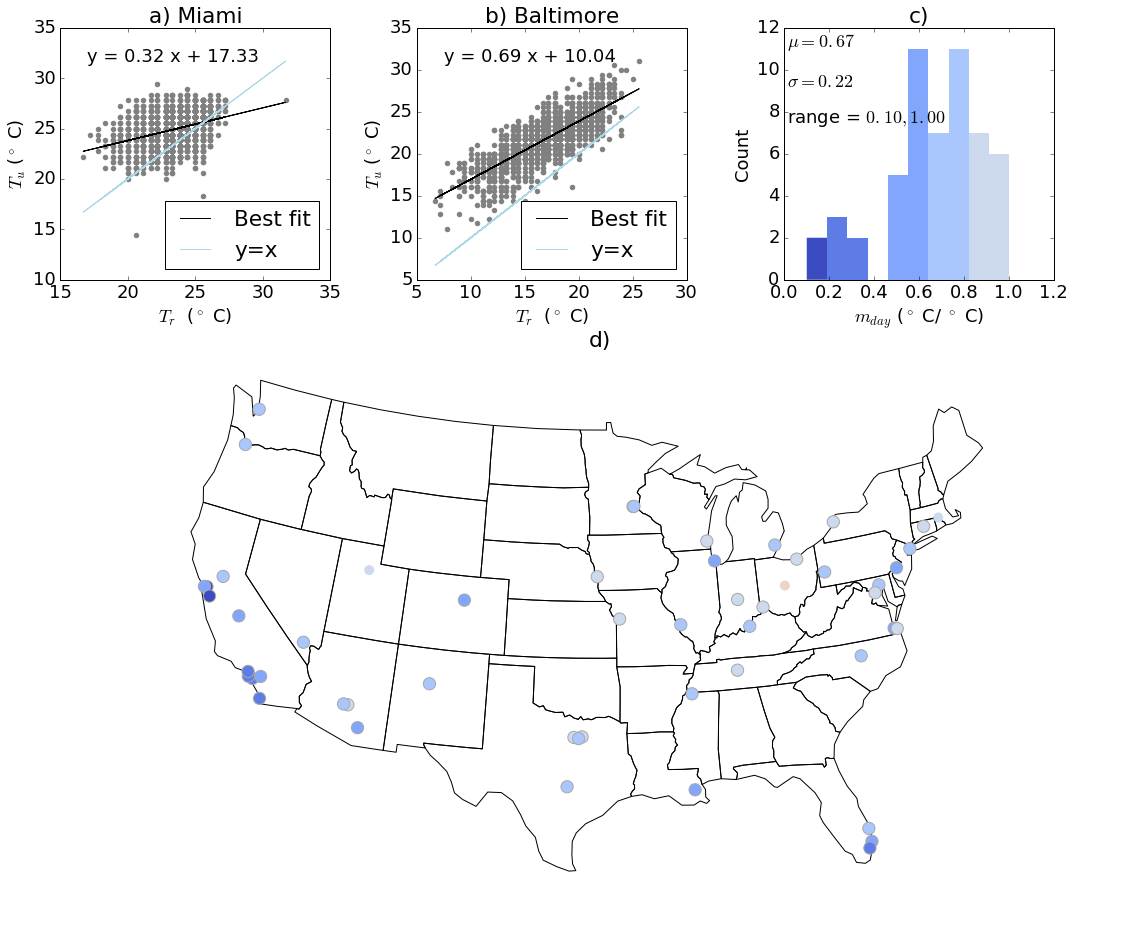

In [38]:
# fig 1 
### map plot

def inset_scatter(x,y,title='', xlabel='', ylabel='') : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    #m,b = np.polyfit(x[ind],y[ind],1)
    #r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    m, b, r, p, sterrest, pvalueWald, pvalueT =  linregress_mod(x[ind], y[ind], null_slope = 1)
    plt.scatter(x[ind],y[ind], color = 'grey')
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.1, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
#    plt.annotate('r = %.2f'%(r), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
#    plt.annotate('p = %.2f'%(pvalueWald), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
#    plt.annotate('N = %i'%(ind.shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, b, r, p, pvalueWald, pvalueT#m, r, p


fig = plt.figure(figsize=[15,10])
#ax = fig.add_subplot(224, projection=ccrs.LambertConformal())
ax = plt.axes([0, 0, 1, 1],
                    projection=ccrs.LambertConformal())
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)

# to get the effect of having just the states without a map "background"
# turn off the outline and background patches
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)
ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
# Plot background state map
for state in shpreader.Reader(states_shp).geometries():
    # pick a default color for the land with a black outline,
    # this will change if the storm intersects with our track
    facecolor = 'None'#[0.9375, 0.9375, 0.859375]
    edgecolor = 'black'
    ax.add_geometries([state], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor=edgecolor, zorder = 0)

# define data
data = results_df['slope']
data = data[~np.isnan(data)]
# Set up colors for plotting
cmap = matplotlib.cm.coolwarm
c = data
bounds = np.linspace(0,2,11)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
marker_size = 150

# plot data
# plotHandle = ax.scatter(paired_df.set_index('City').loc[c.index]['Urban Lon'], paired_df.set_index('City').loc[c.index]['Urban Lat'], 
#                         c = c.values, s = marker_size, alpha = 1, 
#                         transform=ccrs.Geodetic(), edgecolors = 'darkgray', 
#                  cmap = cmap,
#                  norm = norm, zorder = 1, )
c_insignificant = results_df[results_df['pvalueWald'] > 0.05]
ax.scatter(paired_df.set_index('City').loc[c_insignificant.index]['Urban Lon'], paired_df.set_index('City').loc[c_insignificant.index]['Urban Lat'], 
        #paired_df['Urban Lon'].iloc[insig_inds], paired_df['Urban Lat'].iloc[insig_inds], 
            c = c[c_insignificant.index].values, s = marker_size-50, 
           transform=ccrs.Geodetic(),edgecolors= 'None',
           cmap = cmap, norm = norm, zorder =1)        
sig_cities = np.setdiff1d(paired_df.index,c_insignificant.index )
plotHandle = ax.scatter(paired_df.set_index('City').loc[sig_cities]['Urban Lon'], 
                        paired_df.set_index('City').loc[sig_cities]['Urban Lat'], 
                    c = c[sig_cities].values, s = marker_size, alpha = 1, 
                    transform=ccrs.Geodetic(), edgecolors = 'darkgray', 
             cmap = cmap,
             norm = norm, zorder = 1, )
plt.title('d)')

#####
dummy_ind = 0
for city in ['Baltimore', 'Miami']:
    
    urbanID = paired_df.loc[city]['Urban station']
    ruralID = paired_df.loc[city]['Rural station']
    print(city)
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True, update = False)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True, update = False)
    ######
    ###### Import data
    ######
    rural_tmin = pd.to_numeric(ruraldata['TMIN']['2000-01-01':].value/10.) #rural tmin
    urban_tmin = pd.to_numeric(urbandata['TMIN']['2000-01-01':].value/10.) 

    # drop data with flags here
#     rural_tmin.loc[ruraldata['TMIN']['2000-01-01':]['qflag'].dropna().index] = np.nan
#     urban_tmin.loc[urbandata['TMIN']['2000-01-01':]['qflag'].dropna().index] = np.nan
    rural_tmin[~ruraldata['TMIN']['qflag'].isnull()] = np.nan
    urban_tmin[~urbandata['TMIN']['qflag'].isnull()] = np.nan
    # extract summertime data 
    rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
    urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]

#     # clean data: eliminate min temperatures below 4 or above 35
#     rural_summer = rural_summer[(rural_summer>4) & (rural_summer<35)]
#     urban_summer = urban_summer[(urban_summer>4) & (urban_summer < 35)]
        
    #calculate UHI
    UHI = urban_summer - rural_summer
        
    ######
    ###### Daily summertime analysis
    ######
#     a = rural_summer[UHI.index]
#     b = urban_summer[UHI.index]
#     a = a[~np.isnan(a) & ~np.isnan(b)]
#     b = b[~np.isnan(a) & ~np.isnan(b)].values
    
    a = rural_summer[UHI.index]
    b = urban_summer[UHI.index]
    a = a[~np.isnan(a) & ~np.isnan(b)]
    b = b[a.index].values
    if dummy_ind ==0 : 
        #sub_ax1 = plt.axes([0.0, 1.0, 0.25, 0.35])
        sub_ax2 = plt.axes([0.33, 1.0, 0.25, 0.35])

        #sub_ax3 = plt.axes([0.9, 0.0, 0.25, 0.35])
        inset_scatter(a.values, b,'b) %s'%(city),
                  '$T_r$  ($^\circ$ C)', '$ T_u$ ($^\circ$ C)') 
        plt.plot(a.values, a.values, color = 'lightblue')
        plt.legend(['Best fit', 'y=x'], loc =4)
    else: 
        sub_ax1 = plt.axes([0.0, 1.0, 0.25, 0.35])

        #sub_ax2 = plt.axes([0.9, 0.6, 0.25, 0.35])
        inset_scatter(a.values, b,'a) %s'%(city),
                  '$T_r$  ($^\circ$ C)', '$ T_u$ ($^\circ$ C)') 
        plt.plot(a.values, a.values, color = 'lightblue')
        plt.legend(['Best fit', 'y=x'], loc = 4)
    ##### Inset plot     
    dummy_ind = dummy_ind+1
    


sub_ax = plt.axes([0.67, 1.0, 0.25, 0.35])#plt.subplot2grid((3,3), (0,3))
n, bins, patches = sub_ax.hist(data,10, facecolor = 'darkgray', linewidth=0)
# annotate and label 
sub_ax.annotate('$ \mu = %2.2f $'%data.mean(), xy=(0.01, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
sub_ax.annotate('$ \sigma  = %2.2f $'%data.std(), xy=(0.01, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
sub_ax.annotate('range = $%2.2f, %2.2f $'%(data.min(), data.max()), xy=(0.01, .6), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
sub_ax.set_xlabel('$m_{day}$ ($^\circ$ C/ $^\circ$ C)')#data_label) #'m$_{JJA}$ ($^\circ$C$ / ^\circ $C)')
sub_ax.set_ylabel('Count')
sub_ax.set_title('c)')

# set colors 
m = matplotlib.cm.ScalarMappable(norm = norm, cmap = cmap)
m._A = []

bin_centers = 0.5 * (bins[:-1] + bins[1:])
for c,p in zip(bin_centers, patches): # in range(np.size(patches)):
    plt.setp(p,'facecolor', m.to_rgba(c))#color=m.to_rgba(c))
plt.savefig(results_filepath+ 'figure01.pdf', bbox_inches='tight')

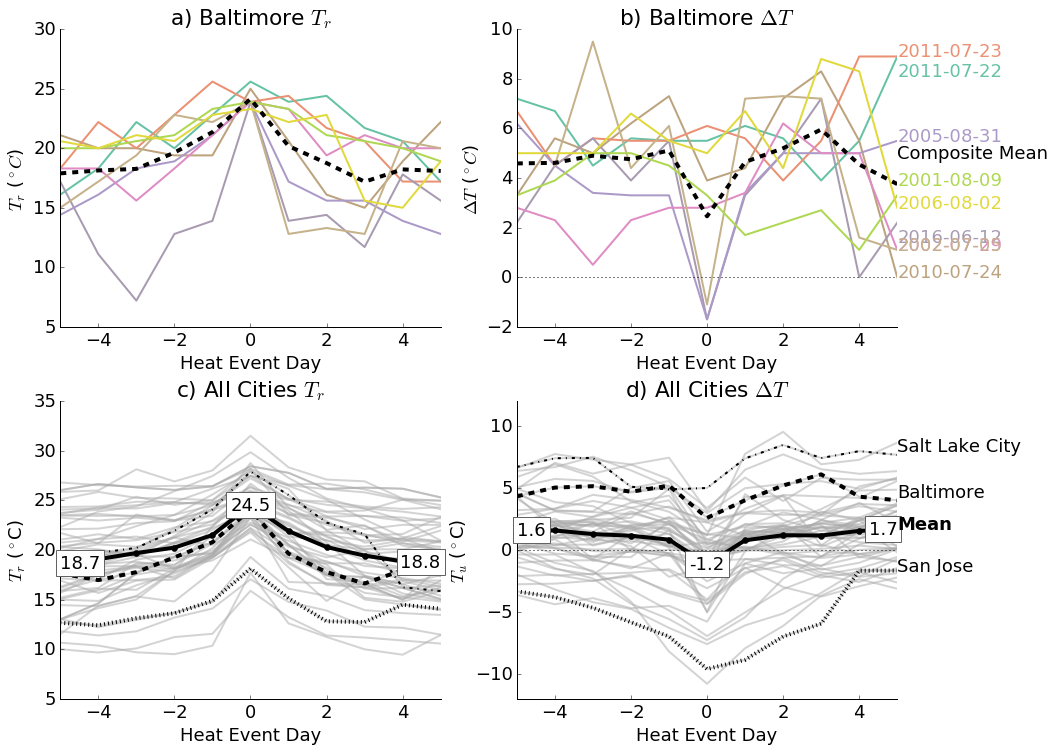

In [86]:
# fig 2 : heatwaves + heatwave sensitivity
# import heatwave composite 
#compositeTemp = pd.read_csv(results_filepath + 'compositetrural.csv')
#compositeU = pd.read_csv(results_filepath + 'compositeturban.csv') 
xx = np.arange(-5,6,1)
compositeUHIDF = pd.read_csv(results_filepath + 'compositetuhi.csv').set_index('City').loc[paired_df.index]
compositeTempDF = pd.read_csv(results_filepath + 'compositetrural.csv').set_index('City').loc[paired_df.index]
compositeUHIDF.columns = xx
compositeTempDF.columns = xx
# ######
# ###### import data
# ######
# numhw = 150
# city = 'Baltimore'
# urbanID = paired_df.loc[city]['Urban station']
# ruralID = paired_df.loc[city]['Rural station']
# print(city)

# # Downloadd from NCDC the station data, using the station ID listed in station list
# urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
#                                      as_dataframe=True, update = False)
# ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
#                                      as_dataframe=True, update = False)
# if ('TMIN' in urbandata.keys()) & ('TMIN' in ruraldata.keys()) & (np.intersect1d(urbandata['TMIN']['2000-01-01':].index, ruraldata['TMIN']['2000-01-01':].index).shape[0] > 300): 
#     ######
#     ###### Import data
#     ######
#     rural_tmin = pd.to_numeric(ruraldata['TMIN']['2000-01-01':].value/10.) #rural tmin
#     urban_tmin = pd.to_numeric(urbandata['TMIN']['2000-01-01':].value/10.) 

#     # drop data with flags here
#     rural_tmin.loc[ruraldata['TMIN']['2000-01-01':]['qflag'].dropna().index] = np.nan
#     urban_tmin.loc[urbandata['TMIN']['2000-01-01':]['qflag'].dropna().index] = np.nan

#     # extract summertime data 
#     rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
#     urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]

#     # clean data: eliminate min temperatures below 4 or above 35

#     ######
#     ###### Compute average heatwave
#     ######

#     hottestmin = rural_summer.iloc[(-rural_summer.values).argsort()[:numhw]] 
#     minheatwaves = hottestmin[0:12]

#     ### make sure that heatwaves aren't duplicates
#     Ns = []
#     m = 0 
#     for n in range(1,10): 
#         old = m
#         try: 
#             while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
#                 m = m+1
#         except IndexError: 
#             minheatwaves = hottestmin[0:20]
#             try: 
#                 while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
#                     m = m+1
#             except IndexError: 
#                 print('out of bounds')
#         try: 
#             if old ==m : 
#                 Ns.append(minheatwaves.sort_index().index[m])
#             else: 
#                 Ns.append(minheatwaves.sort_index()[old:m].argmax())
#         except: 
#             'random error'
#         m = m+1

#     ######
#     ###### Compute the worst heatwaves
#     ######

#     finalhw = hottestmin[Ns].sort_values(ascending=False)
#     compositeTemp = np.nan*np.ones([finalhw.shape[0], 11])
#     compositeUHI = np.nan*np.ones([finalhw.shape[0], 11])
#     ii = 0
#     for dates in finalhw.index[:]: 
#         try: 
#             # note: use rural_tmin in case beginning of hw is before or after summer period
#             compositeTemp[ii,:]= rural_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
#             compositeUHI[ii,:] = (urban_tmin-rural_tmin)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values# -UHI[dates.to_timestamp()]
#         except : 
#             print('skipping %s'%dates)
#         ii = ii+1
            
            
fig = plt.figure(figsize=[15,12])
city1 = 'Salt Lake City'
city2 = 'San Jose'
# city3 = 
# city4 = 

from cycler import cycler
plt.rc('axes', prop_cycle=(cycler('color', plt.cm.Set2(np.linspace(0.0,0.75,10)))))
bmorec = 'k'
plt.subplot(2,2,1)
tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, linewidth = 2)
plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), '--', 
         color = bmorec, 
         linewidth = 4, )
plt.title('a) %s $'%city)
plt.ylabel('$T_r$ ($^\circ C$)')
plt.xlabel('Heat Event Day')
plt.xlim([-5,5])
#plt.legend(legend_str,loc = 2)
prettify_plot()

plt.subplot(2,2,2)    
uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, linewidth = 2)
plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0),
         '--',color = bmorec, linewidth = 4, label = 'Composite Mean Event'),#color = 'black',)

plt.title('b) %s $\Delta T$'%city)
plt.ylabel('$\Delta T $ ($ ^\circ C$)')
plt.xlabel('Heat Event Day')
plt.xlim([-5,5])
prettify_plot()
i = 0
for date in finalhw.index: 
    if ~np.isnan(compositeUHI[i][10]): 
        if i ==0 : 
            plt.text(5, compositeUHI[i][10]-.8, date, color = tHandle[i].get_color()) # 1994-08-03
        elif i ==3: 
            plt.text(5, compositeUHI[i][10]-.8, date, color = tHandle[i].get_color())#, color = plt.cm.viridis(i)) 1993-07-08
        elif i ==7: 
            plt.text(5, compositeUHI[i][10]+.4, date, color = tHandle[i].get_color())# 1993-07-08
        else: 
            plt.text(5, compositeUHI[i][10], date, color = tHandle[i].get_color())#, verticalalignment='center', horizontalalignment='left')#, color = plt.cm.viridis(i))
    else: 
        plt.text(1, compositeUHI[i][6]+1, date, verticalalignment='top', horizontalalignment='center', color = tHandle[i].get_color())#, color = 'red')#plt.cm.viridis(i))

    i = i+1
plt.text(5,np.nanmean(compositeUHI, axis=0)[9]+0.25, 'Composite Mean', color = 'black')
plt.axhline(0, linestyle = ':', color = 'k')

x = np.arange(-5,6)
# plot heatwave composites for all stations
#plt.figure(figsize = [15,5])
#plot temperature,raw
plt.subplot(2,2,3)
for i in range(0, compositeTempDF.shape[0]) : 
    #print compositeUHIDF2.iloc[i].values[1:]
    plt.plot(x, compositeTempDF.iloc[i].values[0:], color = 'DarkGray', zorder = 0, alpha = .5, linewidth = 2)#, '-o')

#plt.errorbar(x,compositeTempDF.mean(), yerr=compositeTempDF.std(), color = 'k', zorder = 1)
#compositeTempDF.mean(axis=0).plot(yerr = compositeTempDF.std(axis=0))
plt.plot(x, compositeTempDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, label = 'Baltimore')
plt.plot(x, compositeTempDF.loc[city1], ':', color = 'k', alpha = 1, linewidth = 4, label = '%s'%city1)
plt.plot(x, compositeTempDF.loc[city2], '-.', color = 'k', alpha = 1, linewidth = 2, label = '%s'%city1)
#plt.plot(x, compositeTempDF.loc['San Jose'], '-o', color = 'DarkGray', zorder = 0, alpha = 1, linewidth = 2, label = 'San Jose')

plt.plot( x, compositeTempDF.mean(), '-o', color = 'k', linewidth = 4)
plt.xlabel('Heat Event Day')
plt.ylabel('$T_r$ ($^\circ$C)')
plt.title('c) All Cities $T_r$')
plt.xlim([-5,5])
xx = -5
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='left')

xx = 0
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'), 
         verticalalignment='center', horizontalalignment='center'
                 )
xx = 5
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='right')

# plt.text(2,compositeTempDF.loc[compositeTempDF.mean(axis=1).argmin()][4],'%s'%compositeTempDF.mean(axis=1).argmin())
# plt.text(2,compositeTempDF.loc[compositeTempDF.mean(axis=1).argmax()][4],'%s'%compositeTempDF.mean(axis=1).argmax())
# plt.text(2,compositeTempDF.loc['Baltimore'][4],'Baltimore', color = bmorec, zorder = 0)
prettify_plot()

#plot UHI, raw
plt.subplot(2,2,4)

for i in range(0, compositeUHIDF.shape[0]) : 
    #print compositeUHIDF2.iloc[i].values[1:]
    plt.plot(x, compositeUHIDF.iloc[i].values[0:], color = 'DarkGray', zorder = 0, alpha = .5, linewidth = 2)#, '-o')
plt.plot( x, compositeUHIDF.mean(), '-o', color = 'k', linewidth = 4,)
#plt.errorbar(x,compositeUHIDF.mean(), yerr=compositeUHIDF.std(), color = 'k', zorder = 1)
plt.axhline(0, linestyle = ':', color = 'k')

plt.xlabel('Heat Event Day')
plt.xlim([-5,5])
plt.ylabel('$T_u$ ($^\circ$C)')
plt.title('d) All Cities $\Delta T$')
prettify_plot()

xx = -5
yy = compositeUHIDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='left')

xx = 0
yy = compositeUHIDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'), 
         verticalalignment='center', horizontalalignment='center'
                 )
xx = 5
yy = compositeUHIDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='right')

# plt.text(5,compositeUHIDF.loc[compositeUHIDF.mean(axis=1).argmin()][4],'%s'%compositeUHIDF.mean(axis=1).argmin())
# plt.text(5,compositeUHIDF.loc[compositeUHIDF.mean(axis=1).argmax()][4],'%s'%compositeUHIDF.mean(axis=1).argmax())
# plt.text(5,compositeUHIDF.loc['Baltimore'][4],'Baltimore', color = bmorec)
# plt.text(5,compositeUHIDF.loc['Phoenix'][4],'Phoenix', color = 'k')
# plt.text(5, compositeUHIDF.mean()[5], 'Mean', color = 'k', weight = 'bold')

# plt.plot(x, compositeUHIDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, label = 'Baltimore')
# plt.plot(x, compositeUHIDF.loc['Albuquerque'], '-.', color = 'k', alpha = 1, linewidth = 2, label = 'Albuquerque')
# plt.plot(x, compositeUHIDF.loc['San Jose'], '-o', color = 'DarkGray', zorder = 0, alpha = 1, linewidth = 2, label = 'San Jose')
# plt.plot(x, compositeUHIDF.loc['Phoenix'], ':', color = 'k', zorder = 0, alpha = 1, linewidth = 4, label = 'Phoenix')

plt.text(5,compositeUHIDF.loc[compositeUHIDF.mean(axis=1).argmin()][4],'%s'%compositeUHIDF.mean(axis=1).argmin())
plt.text(5,compositeUHIDF.loc[compositeUHIDF.mean(axis=1).argmax()][4],'%s'%compositeUHIDF.mean(axis=1).argmax())
plt.text(5,compositeUHIDF.loc['Baltimore'][4],'Baltimore', color = bmorec)
#plt.text(5,compositeUHIDF.loc['Dallas'][4],'Dallas', color = 'k')

plt.text(5, compositeUHIDF.mean()[5], 'Mean', color = 'k', weight = 'bold')
plt.plot(x, compositeUHIDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, 
         label = 'Baltimore')
plt.plot(x, compositeUHIDF.loc[city1], '-.', color = 'k', alpha = 1, linewidth = 2, 
         label = '%s'%city1)
# plt.plot(x, compositeUHIDF.loc['San Bernardino'], '-o', color = 'DarkGray', zorder = 0, alpha = 1, linewidth = 2, 
#          label = 'San Bernadino')
plt.plot(x, compositeUHIDF.loc[city2], ':', color = 'k', zorder = 0, alpha = 1, linewidth = 4, 
         label = '%s'%city2)
plt.ylim([-12,12])
fig.subplots_adjust(hspace = .25)
# #plt.legend(loc = 'center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig(results_filepath+ 'hwcompositeTMIN.pdf',bbox_inches='tight')

# # extreme heatwave sensitivity map
# data = results_df['hw_slope']
# fig, ax, sub_ax = map_hist_plot(data, paired_df, title = 'Heatwaves', 
#                     data_label='$m_{hw}$ ($^\circ$ C/ $^\circ $C)',
#                    c_insignificant = results_df[results_df['hw_pvalueWald']>0.05]
#                 ) 
# sub_ax.set_xticks(sub_ax.get_xticks()[::2])
# ax.set_title('e)')
# sub_ax.set_title('f)')
# plt.savefig(results_filepath+ 'avg_hw_map.pdf', bbox_inches='tight')

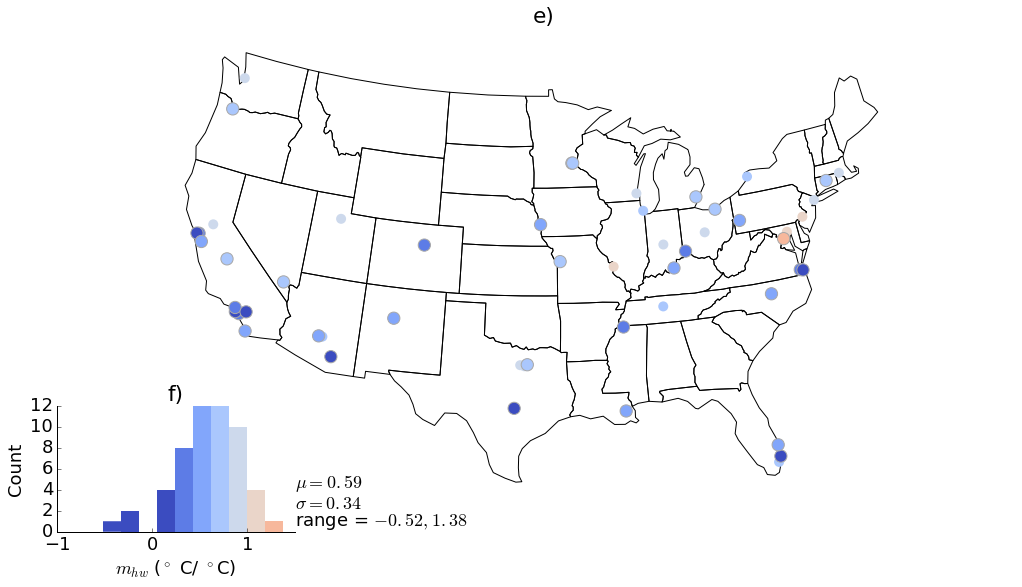

In [8]:
# extreme heatwave sensitivity map
data = results_df['hw_slope']
fig, ax, sub_ax = map_hist_plot(data, paired_df, title = 'Heatwaves', 
                    data_label='$m_{hw}$ ($^\circ$ C/ $^\circ $C)',
                   c_insignificant = results_df[results_df['hw_pvalueWald']>0.05]
                ) 
sub_ax.set_xticks(sub_ax.get_xticks()[::2])
ax.set_title('e)')
sub_ax.set_title('f)')
plt.savefig(results_filepath+ 'avg_hw_map.pdf', bbox_inches='tight')

In [ ]:
# fig 3: dry-moist analysis

0.0216525708115


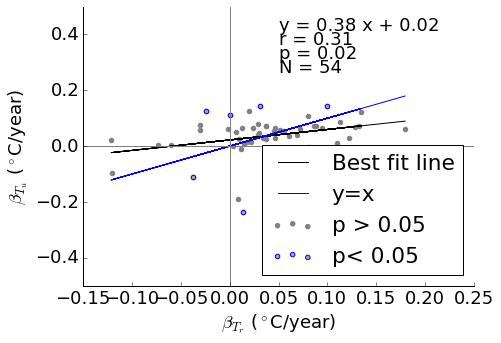

In [60]:
# fig 4 : changes over time 
# plot mean urban trends versus mean rural trends

# load error bars
results_filepath_error_bars = 'plots/version6/errorbars/trend/' 
cities = paired_df['City'].values
rural_std = pd.DataFrame([], index = paired_df.index, columns=['StdDev'])
trend_list = []
for i in range(0,paired_df.shape[0]): # probalby need to redo 1-15
    city = paired_df.iloc[i]['City']
#     if city == 'Grand Prairie': 
#         city = 'Arlington'
    try: 
        array = np.load(results_filepath_error_bars+ city.replace(" ", "")[0:5]+'Trtrend.npy')
        array = array[~np.isnan(array)]
        #rural_std.append(array.std())
        trend_list.append(array)
        rural_std.loc[city, 'StdDev'] = array.std()
    except IOError: 
        print('Skipping %s'%city)
rural_std.loc['New Orleans'] = np.nan       
x = results_df['trend_r']
y =  results_df['trend_u']
plt.figure(figsize=[7,5])
# plt.errorbar(x, y, yerr = slopes_std, fmt='o', alpha = .5,#markersize='10', 
#              color = 'DarkGray', zorder =0)
#plt.errorbar(x.values, y[x.index].values, xerr = rural_std.loc[x.index].values, fmt='o', color = 'DarkGray')

m, r, p = easy_scatter(results_df['trend_r'].values,results_df['trend_u'].values,
           '', r'$\beta_{T_r}$ ($^\circ$C/year)', #30-year JJA Trend Relationship
           r'$\beta_{T_u}$ ($^\circ$C/year)')
plt.plot(x,x)

plt.scatter(results_df[(results_df['trend_r_p'] < .05) & (results_df['trend_u_p']<.05)]['trend_r'], 
           results_df[(results_df['trend_r_p'] < .05) & (results_df['trend_u_p']<.05)]['trend_u'], 
           color = 'darkgray', edgecolor = 'blue', zorder =1)

plt.legend(['Best fit line', 'y=x' ,'p > 0.05', 'p< 0.05'], loc = 4)

plt.axhline(0, color = 'gray')
plt.axvline(0, color = 'gray')
plt.ylim([-0.5,.5])
prettify_plot()
plt.savefig(results_filepath+'figure03_15years.pdf', bbox_inches='tight')
print(p)

(-1, 2)

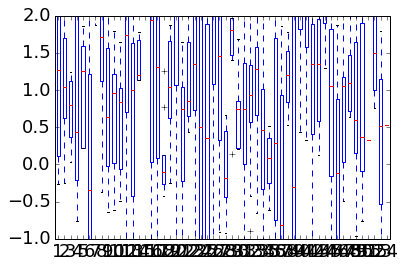

In [63]:
handle = plt.boxplot(trend_list)
plt.ylim([-1,2])

In [14]:
ls plots/version6/errorbars/

slopes/ trend/  values/


In [20]:
rural_std = pd.DataFrame([], index = paired_df.index, columns=['StdDev'])


1.11423259585e-12


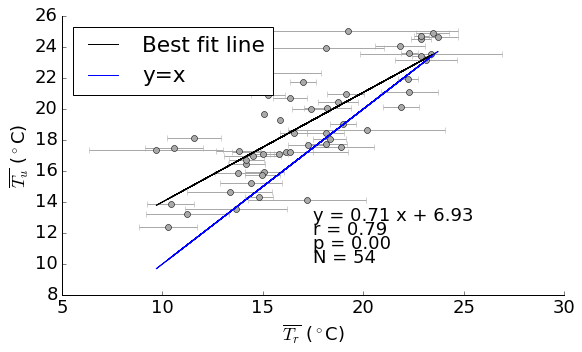

In [79]:
# fig 4 : changes over space

# load error bars
results_filepath_error_bars = 'plots/version6/errorbars/values/' 
cities = paired_df['City'].values
rural_std = pd.DataFrame([], index = paired_df.index, columns=['StdDev'])
for i in range(0,paired_df.shape[0]): # probalby need to redo 1-15
    city = paired_df.iloc[i]['City']
#     if city == 'Grand Prairie': 
#         city = 'Arlington'
    try: 
        array = np.load(results_filepath_error_bars+ city.replace(" ", "")[0:5]+'rural.npy')
        array = array[~np.isnan(array)]
        #rural_std.append(array.std())
        rural_std.loc[city, 'StdDev'] = array.std()
    except IOError: 
        print('Skipping %s'%city)
        
# plot mean urban versus mean rural
plt.figure(figsize=[9,5])
x = results_df['mean rural']
y = results_df['mean urban']
plt.errorbar(x.values, y[x.index].values, xerr = rural_std.loc[x.index].values, fmt='o', color = 'DarkGray')
m,r,p = easy_scatter(x.dropna().astype(float),y.dropna().astype(float),
             '', 
             '$\overline{T_r}$ ($^\circ$C)', '$\overline{T_u}$ ($^\circ$C)', 
                    text_y_loc = .25)
plt.plot(x,x)
prettify_plot()
plt.legend(['Best fit line', 'y=x'], loc = 2)
plt.savefig(results_filepath+ 'figure04.pdf',bbox_inches='tight')
print(p)

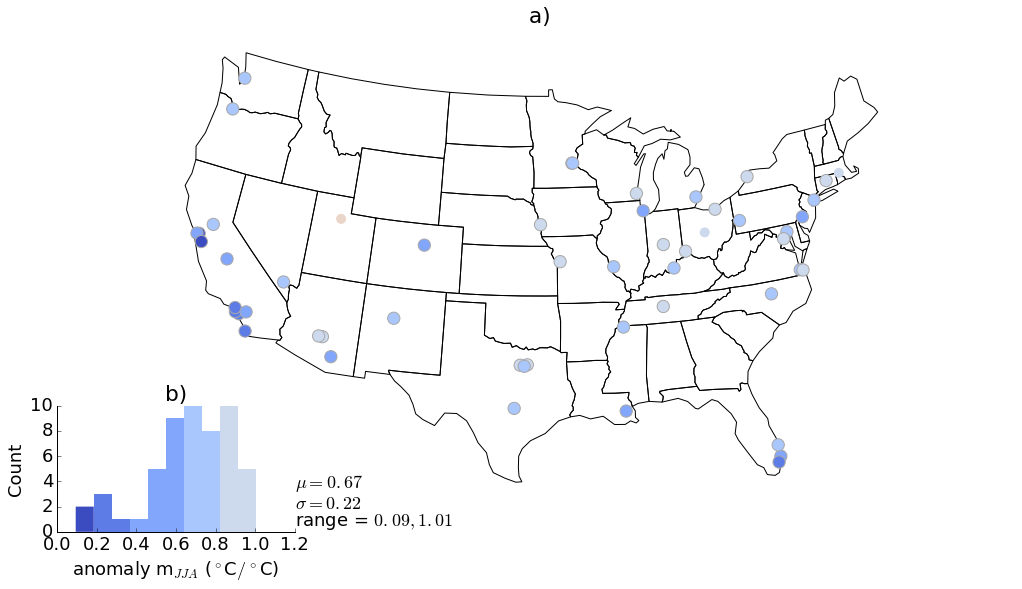

In [9]:
#### supplemental figures

data = results_df['anom_slope']#.drop(drop_cities, axis = 0)['Anomaly m']
fig = map_hist_plot(data, paired_df, title = 'Response of Anomaly $\Delta T$ to Temperature Change', 
                    data_label = 'anomaly m$_{JJA}$ ($^\circ$C$ / ^\circ $C)', 
                   c_insignificant = results_df[results_df['anom_pvalueT']>0.05]) 
plt.savefig(results_filepath+ 'anomalyJJAslopes.pdf', bbox_inches='tight')

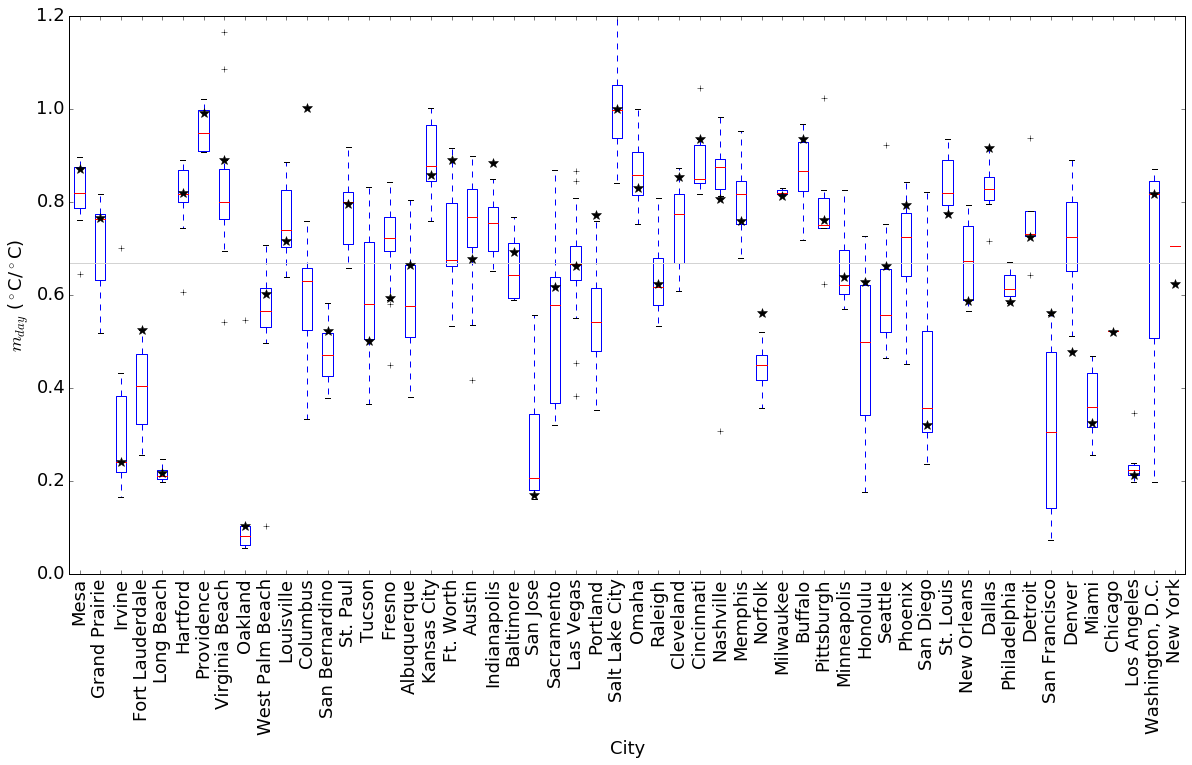

In [81]:
results_filepath_error_bars = 'plots/version6/errorbars/slopes/' 
cities = paired_df['City'].values
M_list = []
rural_std = pd.DataFrame([], index = paired_df.index, columns=['StdDev'])
for i in range(0,paired_df.shape[0]): # probalby need to redo 1-15
    city = paired_df.iloc[i]['City']
#     if city == 'Grand Prairie': 
#         city = 'Arlington'
    try: 
        array = np.load(results_filepath_error_bars+ city.replace(" ", "")[0:5]+'m.npy')
        array = array[~np.isnan(array)]
        #rural_std.append(array.std())
        M_list.append(array)
    except IOError: 
        print('Skipping %s'%city)
        
plt.figure(figsize=[20,10])
ax = plt.subplot(111) 
ax.boxplot(M_list, vert = True)
ax.hold('True')
#Now load the calculated results 
#JJAresults = pd.read_csv('US_results_cleaned_data.csv').set_index('City')
#set up fake x axis
X = np.arange(1, cities.shape[0]+1)
Y = results_df['slope'].loc[cities]
ax.axhline(Y.mean(), color = 'lightgray', label = '$\overline{m}$, this study')
#ax.axhline(0, color = 'black', )
ax.plot(X,Y, '*', color = 'black', markerSize = 10, label = 'This study $m$')
ax.set_xlabel('City')
ax.set_xticklabels(cities, rotation = 90)
ax.set_ylabel('$m_{day}$ ($^\circ$C/$^\circ$C)')
#ax.set_title('Slope of UHI response to Temperature')
#plt.ylim([0, 2.0])
plt.savefig(results_filepath+ 'slope_boxplot.pdf', bbox_inches='tight')

/Users/ascott47/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:17: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


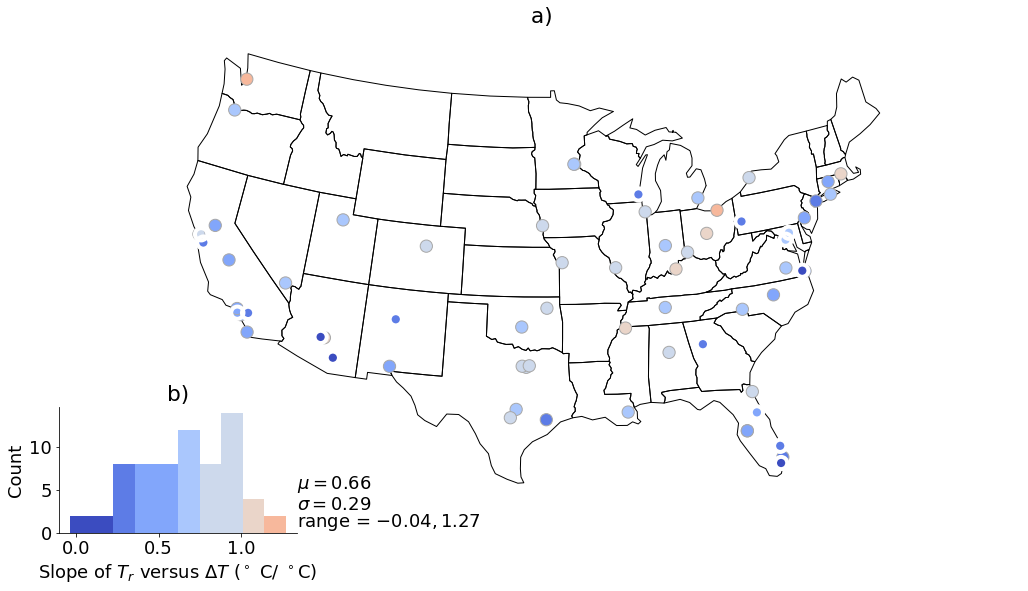

In [157]:
# change over time: summer annual temps versus UHI
data = results_df['mean_summer_tvsdt_m']
fig = map_hist_plot(data, paired_df, title = 'Slope of summer mean $T_r$ versus $T_u$', 
                    data_label='Slope of $T_r$ versus $\Delta T$ ($^\circ$ C/ $^\circ $C)', 
                  c_insignificant = results_df[results_df['mean_summer_tvsdt_p']>0.05]) 
plt.savefig(results_filepath+ 'summer_mean_slopes.pdf', bbox_inches='tight')

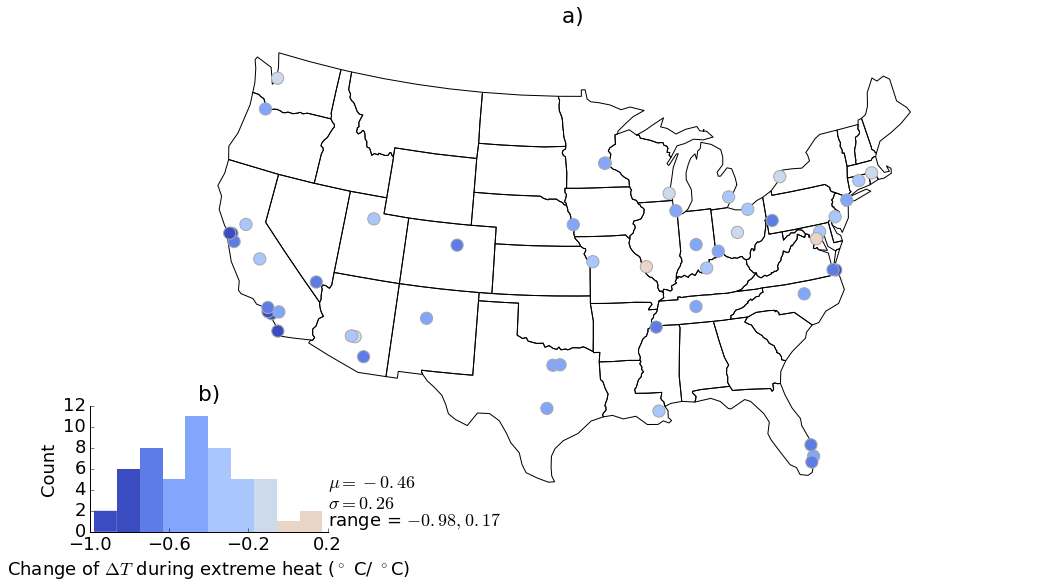

In [12]:
# extreme hewatwave sensitivity
xx = np.arange(-5,6,1)
compositeUHIDF = pd.read_csv(results_filepath + 'compositetuhi.csv').set_index('City').loc[paired_df.index]
compositeTempDF = pd.read_csv(results_filepath + 'compositetrural.csv').set_index('City').loc[paired_df.index]
compositeUHIDF.columns = xx
compositeTempDF.columns = xx
data = compositeUHIDF[0].subtract(compositeUHIDF[-5])/compositeTempDF[0].subtract(compositeTempDF[-5])#.drop(drop_cities)
fig, ax, sub_ax = map_hist_plot(data, paired_df, title = 'Extreme Heat Events', 
                    data_label='Change of $\Delta T$ during extreme heat ($^\circ$ C/ $^\circ $C)', 
                    bounds = np.linspace(-1,1,11)
                ) 
sub_ax.set_xticks(sub_ax.get_xticks()[::2])
plt.savefig(results_filepath+ 'extreme_hw_map.pdf', bbox_inches='tight')

In [69]:
toc = time.time() #time
anomaly_results = np.nan*np.ones([paired_df.shape[0], 3])
mean_summer_tvsdt = np.nan*np.ones([paired_df.shape[0], 3])
for i in range(0, paired_df.shape[0]): 
    city = paired_df.iloc[i]['City']
    city = unicode(city, errors = 'ignore')
    urbanID = paired_df.iloc[i]['Urban station']
    ruralID = paired_df.iloc[i]['Rural station']
    print city
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True, update = False)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True, update = False)
    if ('TMIN' in urbandata.keys()) & ('TMIN' in ruraldata.keys()) & (np.intersect1d(urbandata['TMIN']['1985-01-01':].index, ruraldata['TMIN']['1985-01-01':].index).shape[0] > 300): 
        ######
        ###### Import data
        ######
        rural_tmin = pd.to_numeric(ruraldata['TMIN']['1985-01-01':].value/10.) #rural tmin
        urban_tmin = pd.to_numeric(urbandata['TMIN']['1985-01-01':].value/10.) 
        
        rural_start_date[i] = rural_tmin[~np.isnan(rural_tmin)].index[0].year
        rural_end_date[i]   = rural_tmin[~np.isnan(rural_tmin)].index[-1].year
        urban_start_date[i] = urban_tmin[~np.isnan(urban_tmin)].index[0].year
        urban_end_date[i]   = urban_tmin[~np.isnan(urban_tmin)].index[-1].year
        
        # extract summertime data 
#         rural_summer = rural_tmin[np.logical_or(rural_tmin.index.month==6, rural_tmin.index.month==7, rural_tmin.index.month==8)]
#         urban_summer = urban_tmin[np.logical_or(urban_tmin.index.month==6, urban_tmin.index.month==7, urban_tmin.index.month==8)]
        rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
        urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]
        
        # clean data: eliminate min temperatures below 4 or above 35
        rural_summer = rural_summer[(rural_summer>4) & (rural_summer<35)]
        urban_summer = urban_summer[(urban_summer>4) & (urban_summer < 35)]
        
        #calculate UHI
        UHI = urban_summer - rural_summer
        # calculate anomalies 
        clim = rural_summer.groupby(rural_summer.index.year).mean()
        x = rural_summer - clim[rural_summer.index.year].values # anomaly temperature
        clim_deltaT = UHI.groupby(UHI.index.year).mean()
        y = UHI - clim_deltaT[UHI.index.year].values # anomaly UHI
        ind = ~np.isnan(y) & ~np.isnan(x)
        # plot daily T' vs Delta T'
        m,r,p = color_scatter(x[ind], y[ind], '%s JJA Anomaly Temp versus $\Delta T$'%city, 'Anomaly T ($^\circ$C)', 'Anomaly $\Delta T$ ($ ^\circ$ C)')
        plt.savefig(results_filepath+ 'anomalyJJA/'+'JJAUHI%s%s.png'%(city.replace(" ", "")[0:5], 'min'))
        plt.close()        
        anomaly_results1[i,:] = m,r,p
                #save out
        # plot summer mean values against each other 
        x = rural_summer.groupby(rural_summer.index.year).mean()
        y = UHI.groupby(UHI.index.year).mean()
        ind = ~np.isnan(y) & ~np.isnan(x)

        m,r,p = color_scatter_years(x[ind], y[ind], 
                      '%s Summer Mean JJA Temp versus Summer Mean$\Delta T$'%city, 
                      '$T_r$ ($^\circ$C)', 
                      '$\Delta T$ ($ ^\circ$ C)')
        plt.savefig(results_filepath+ 'summermeans/'+'summermeanTvDT%s%s.png'%(city.replace(" ", "")[0:5], 'min'))
        plt.close()        
        mean_summer_tvsdt[i,:] = m,r,p

        if np.mod(i,10) == 0 : 
            pd.DataFrame(anomaly_results1, columns= ['Anomaly m', 'Anomaly r', 'Anomaly p']).to_csv(results_filepath+'anomalyJJA/'+'anomaly_results1.csv')
            pd.DataFrame(mean_summer_tvsdt, columns= ['m', 'r', 'p-value']).to_csv(results_filepath+'summermeans/'+'mean_summer_tvsdt_results.csv')            
pd.DataFrame(anomaly_results, columns= ['Anomaly m', 'Anomaly r', 'Anomaly p']).to_csv(results_filepath+'anomalyJJA/'+'anomaly_results.csv')
pd.DataFrame(mean_summer_tvsdt, columns= ['m', 'r', 'p-value']).to_csv(results_filepath+'summermeans/'+'mean_summer_tvsdt_results.csv')
#anomaly_results = pd.read_csv(results_filepath+'anomalyJJA/'+'anomaly_results.csv')

New Haven
Fort Lauderdale
Hartford
Providence
Birmingham
St. Petersburg
Oakland
West Palm Beach
Charlotte
Columbus
Fresno
Tulsa
Ft. Worth
Austin
El Paso
Orlando
Jacksonville
Indianapolis
Richmond
Baltimore
San Jose
Sacramento
Portland
Salt Lake City
Omaha
San Antonio
Raleigh
Cleveland
Cincinnati
Nashville
Memphis
Norfolk
Buffalo
Pittsburgh
Minneapolis
Honolulu
Seattle
Phoenix
San Diego
St. Louis
New Orleans
Dallas
Tampa
Philadelphia
Denver
Houston
Miami
Atlanta
Chicago
Los Angeles
Washington, D.C.
New York


In [57]:
pd.DataFrame(anomaly_results1, columns= ['Anomaly m', 'Anomaly r', 'Anomaly p']).to_csv(results_filepath+'anomalyJJA/'+'anomaly_results.csv')
pd.DataFrame(mean_summer_tvsdt, columns= ['m', 'r', 'p-value']).to_csv(results_filepath+'summermeans/'+'mean_summer_tvsdt_results.csv')
#anomaly_r

In [90]:
results_filepath

'plots/version3/'

In [101]:
# read in anomaly data
composite_cities = pd.read_csv(results_filepath + results_filename)['City']
anomaly_results = pd.read_csv('plots/version2/'+'anomalyJJA/'+'anomaly_results1.csv').set_index(composite_cities).loc[results_df.index]

In [19]:
results_df = pd.read_csv(results_filepath + results_filename)#.drop(2)
results_df = results_df.set_index('City').loc[paired_df.index]

In [7]:
results_df = pd.read_csv(results_filepath + results_filename).drop(1).set_index('City')
results_df = results_df[results_df['Data points']>0]

In [6]:
city = 'Baltimore'
#city = unicode(city, errors = 'ignore')
urbanID = paired_df.loc[city]['Urban station']
ruralID = paired_df.loc[city]['Rural station']
# Downloadd from NCDC the station data, using the station ID listed in station list
urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                     as_dataframe=True, update = False)
ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                     as_dataframe=True, update = False)


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vi

In [7]:
rural_tmin = pd.to_numeric(ruraldata['TMIN']['1985-01-01':].value/10.) #rural tmin
urban_tmin = pd.to_numeric(urbandata['TMIN']['1985-01-01':].value/10.)         
# extract summertime data 
rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]
# clean data: eliminate min temperatures below 4 or above 35
rural_summer = rural_summer[(rural_summer>4) & (rural_summer<35)]
urban_summer = urban_summer[(urban_summer>4) & (urban_summer < 35)]

#calculate UHI
UHI = urban_summer - rural_summer

(0.26743525953896563, 0.35625273026594145, 1.4857686353592383e-76)

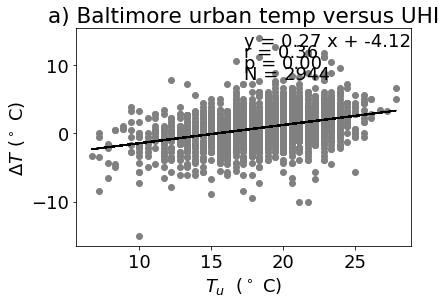

In [9]:
hw_scatter(urban_summer[UHI.index], UHI,'a) %s urban temp versus UHI'%(city),
                  '$T_u$  ($^\circ$ C)', '$\Delta T$ ($^\circ$ C)') 

(-0.016408823654168243, -0.020428460330335779, 0.30445368346032192)

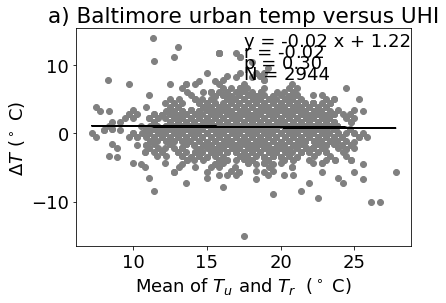

In [11]:
hw_scatter((urban_summer[UHI.index] + rural_summer[UHI.index])*.5, UHI,'a) %s urban temp versus UHI'%(city),
                  'Mean of $T_u$ and $T_r$  ($^\circ$ C)', '$\Delta T$ ($^\circ$ C)') 

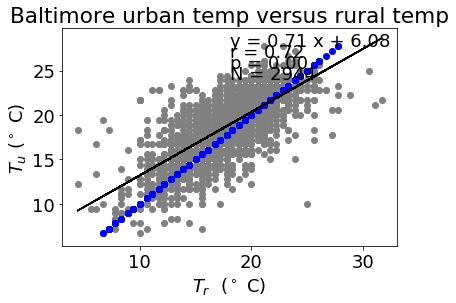

In [20]:
hw_scatter(rural_summer[UHI.index], urban_summer[UHI.index], '%s urban temp versus rural temp'%(city),
                  '$T_r$  ($^\circ$ C)', '$ T_u$ ($^\circ$ C)') 
plt.scatter(urban_summer[UHI.index], urban_summer[UHI.index], color = 'blue', label = 'y=x line')

(0.74870833629304923, 0.72588438319540782, 0.0)

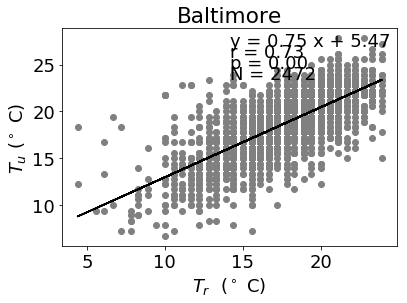

In [30]:
hw_scatter(rural_summer[UHI.index][rural_summer[UHI.index] < 24], 
           urban_summer[UHI.index][rural_summer[UHI.index] < 24],
           '%s'%(city),
                  '$T_r$  ($^\circ$ C)', '$ T_u$ ($^\circ$ C)') 

(-0.027107116670968934, -0.018613692472061603, 0.83676392972780123)

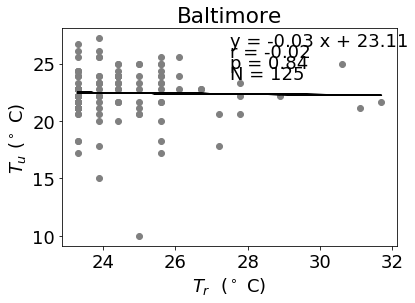

In [31]:
hw_scatter(rural_summer[UHI.index][rural_summer[UHI.index] > 23], 
           urban_summer[UHI.index][rural_summer[UHI.index] > 23],
           '%s'%(city),
                  '$T_r$  ($^\circ$ C)', '$ T_u$ ($^\circ$ C)') 

TypeError: not all arguments converted during string formatting

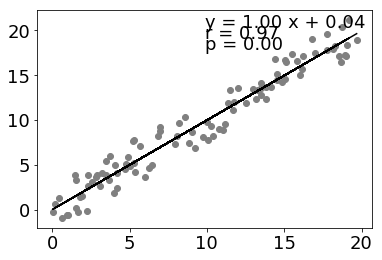

In [155]:
a= np.random.rand(100,1)*20
b = a + (np.random.rand(100,1)-.5)*5
hw_scatter(a,b, ' ', ' ', ' ')

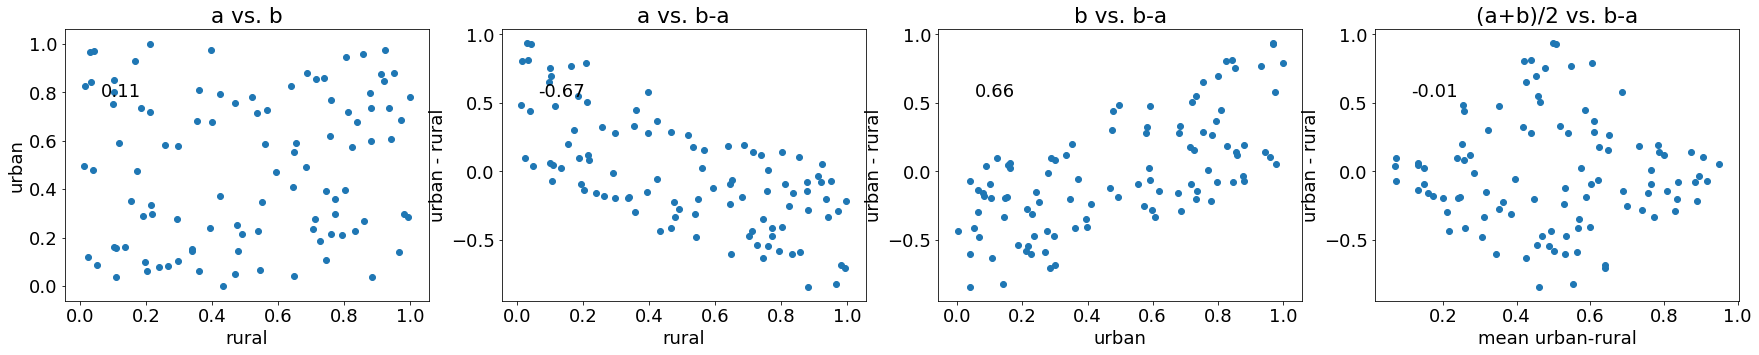

In [118]:
# case 1- random variables
import random
a= np.random.rand(100,1)
b = np.random.rand(100,1)

plt.figure(figsize = [30,5])
plt.subplot(141)
plt.scatter(a,b)
plt.title('a vs. b')
plt.xlabel('rural')
plt.ylabel('urban')
plt.annotate('%2.2f'%scipy.stats.pearsonr(a,b)[0][0], xy = (0.1, .75), xycoords='axes fraction', )


plt.subplot(142)
plt.scatter(a,b-a)
plt.title('a vs. b-a')
plt.xlabel('rural')
plt.ylabel('urban - rural')
plt.annotate('%2.2f'%scipy.stats.pearsonr(a,b-a)[0][0], xy = (0.1, .75), xycoords='axes fraction', )


plt.subplot(143)
plt.scatter(b,b-a)
plt.title('b vs. b-a')
plt.xlabel('urban')
plt.ylabel('urban - rural')
plt.annotate('%2.2f'%scipy.stats.pearsonr(b,b-a)[0][0], xy = (0.1, .75), xycoords='axes fraction', )

plt.subplot(144)
plt.scatter(.5*(a+b), b-a)
plt.title('(a+b)/2 vs. b-a')
plt.xlabel('mean urban-rural')
plt.ylabel('urban - rural')
plt.annotate('%2.2f'%scipy.stats.pearsonr(.5*(a+b),b-a)[0][0], xy = (0.1, .75), xycoords='axes fraction', )


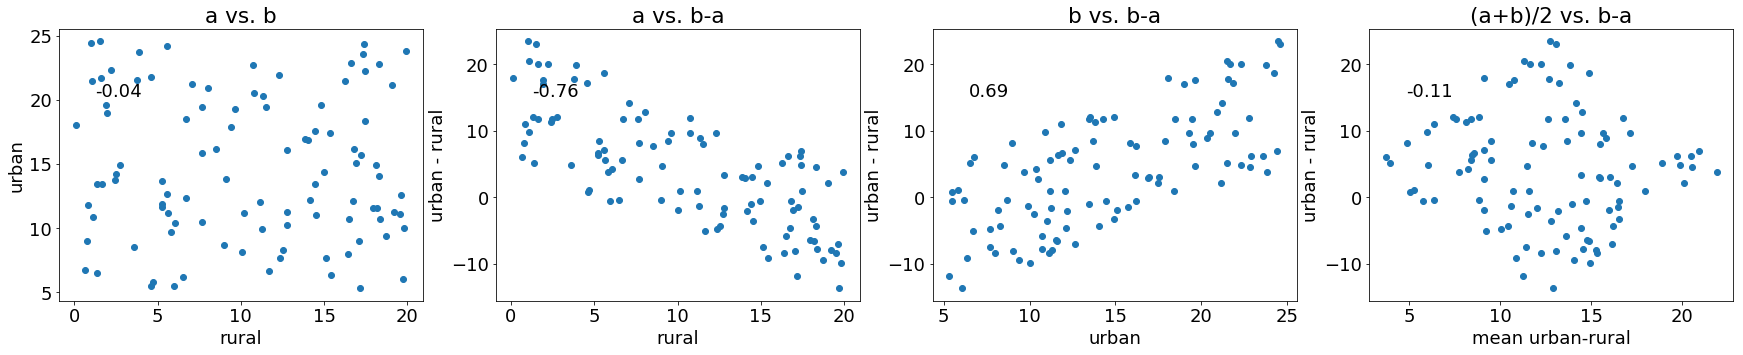

In [119]:
# case 2- random variables, linearly separated
# a = rural 
# b = urban
import random
a= np.random.rand(100,1)*20
b = np.random.rand(100,1)*20 + 5

plt.figure(figsize = [30,5])
plt.subplot(141)
plt.scatter(a,b)
plt.title('a vs. b')
plt.xlabel('rural')
plt.ylabel('urban')
plt.annotate('%2.2f'%scipy.stats.pearsonr(a,b)[0][0], xy = (0.1, .75), xycoords='axes fraction', )


plt.subplot(142)
plt.scatter(a,b-a)
plt.title('a vs. b-a')
plt.xlabel('rural')
plt.ylabel('urban - rural')
plt.annotate('%2.2f'%scipy.stats.pearsonr(a,b-a)[0][0], xy = (0.1, .75), xycoords='axes fraction', )


plt.subplot(143)
plt.scatter(b,b-a)
plt.title('b vs. b-a')
plt.xlabel('urban')
plt.ylabel('urban - rural')
plt.annotate('%2.2f'%scipy.stats.pearsonr(b,b-a)[0][0], xy = (0.1, .75), xycoords='axes fraction', )

plt.subplot(144)
plt.scatter(.5*(a+b), b-a)
plt.title('(a+b)/2 vs. b-a')
plt.xlabel('mean urban-rural')
plt.ylabel('urban - rural')
plt.annotate('%2.2f'%scipy.stats.pearsonr(.5*(a+b),b-a)[0][0], xy = (0.1, .75), xycoords='axes fraction', )


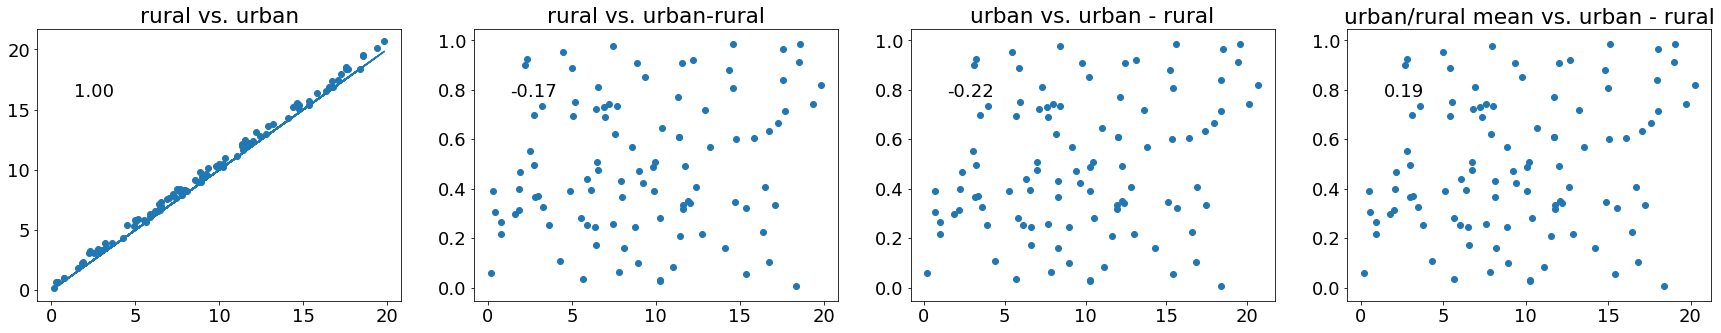

In [123]:
# case 3: urban a random, b = a + X
# a = rural 
# b = urban
a= np.random.rand(100,1)*20
b = a + np.random.rand(100,1)

plt.figure(figsize = [30,5])
plt.subplot(141)
plt.scatter(a,b)
plt.plot(a,a)
plt.title('rural vs. urban')
plt.annotate('%2.2f'%scipy.stats.pearsonr(a,b)[0][0], xy = (0.1, .75), xycoords='axes fraction', )

plt.subplot(142)
plt.scatter(a,b-a)
plt.title('rural vs. urban-rural')
plt.annotate('%2.2f'%scipy.stats.pearsonr(a,a-b)[0][0], xy = (0.1, .75), xycoords='axes fraction', )

plt.subplot(143)
plt.scatter(b,b-a)
plt.title('urban vs. urban - rural')
plt.annotate('%2.2f'%scipy.stats.pearsonr(b,a-b)[0][0], xy = (0.1, .75), xycoords='axes fraction', )

plt.subplot(144)
plt.scatter((a+b)*.5,b-a)
plt.title('urban/rural mean vs. urban - rural')
plt.annotate('%2.2f'%scipy.stats.pearsonr((a+b)*.5,b-a)[0][0], xy = (0.1, .75), xycoords='axes fraction', )


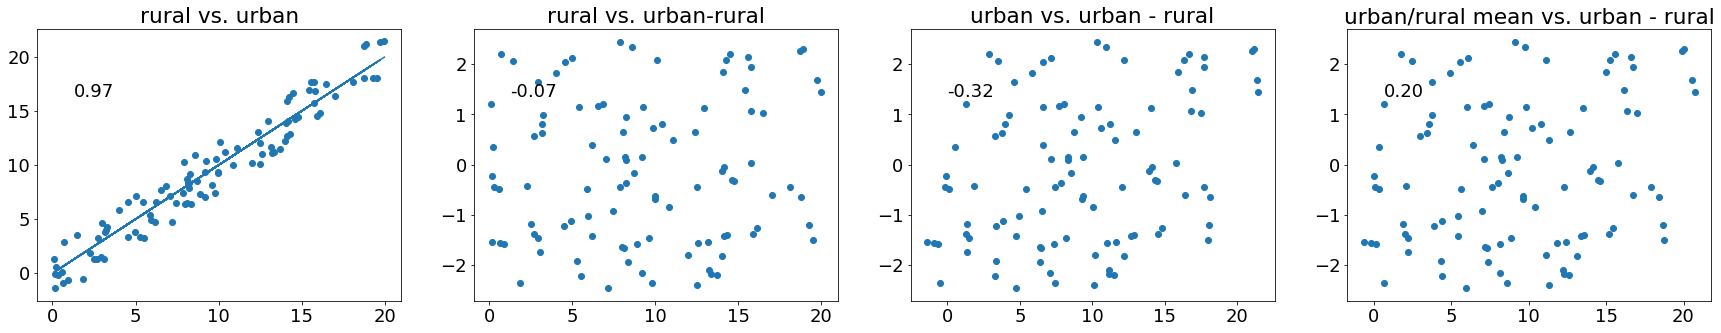

In [125]:
# case 3 : urban a random, b = a + x
# a = rural 
# b = urban
a= np.random.rand(100,1)*20
b = a + (np.random.rand(100,1)-.5)*5

plt.figure(figsize = [30,5])
plt.subplot(141)
plt.scatter(a,b)
plt.plot(a,a)
plt.title('rural vs. urban')
plt.annotate('%2.2f'%scipy.stats.pearsonr(a,b)[0][0], xy = (0.1, .75), xycoords='axes fraction', )

plt.subplot(142)
plt.scatter(a,b-a)
plt.title('rural vs. urban-rural')
plt.annotate('%2.2f'%scipy.stats.pearsonr(a,a-b)[0][0], xy = (0.1, .75), xycoords='axes fraction', )

plt.subplot(143)
plt.scatter(b,b-a)
plt.title('urban vs. urban - rural')
plt.annotate('%2.2f'%scipy.stats.pearsonr(b,a-b)[0][0], xy = (0.1, .75), xycoords='axes fraction', )

plt.subplot(144)
plt.scatter((a+b)*.5,b-a)
plt.title('urban/rural mean vs. urban - rural')
plt.annotate('%2.2f'%scipy.stats.pearsonr((a+b)*.5,b-a)[0][0], xy = (0.1, .75), xycoords='axes fraction', )

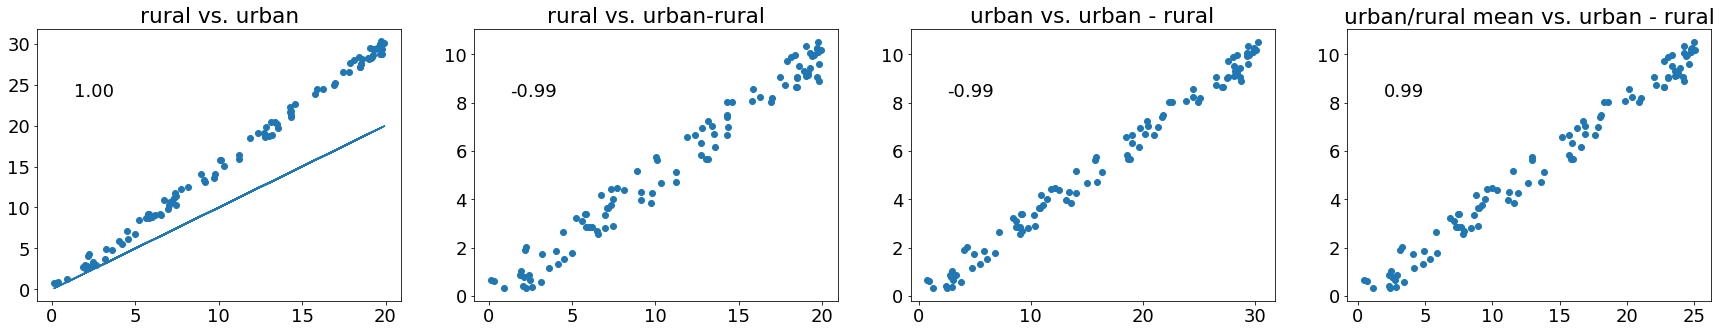

In [126]:
# a = rural 
# b = urban
a= np.random.rand(100,1)*20
b = a*1.5 + (np.random.rand(100,1)-.5)*2
plt.figure(figsize = [30,5])
plt.subplot(141)
plt.scatter(a,b)
plt.plot(a,a)
plt.title('rural vs. urban')
plt.annotate('%2.2f'%scipy.stats.pearsonr(a,b)[0][0], xy = (0.1, .75), xycoords='axes fraction', )

plt.subplot(142)
plt.scatter(a,b-a)
plt.title('rural vs. urban-rural')
plt.annotate('%2.2f'%scipy.stats.pearsonr(a,a-b)[0][0], xy = (0.1, .75), xycoords='axes fraction', )

plt.subplot(143)
plt.scatter(b,b-a)
plt.title('urban vs. urban - rural')
plt.annotate('%2.2f'%scipy.stats.pearsonr(b,a-b)[0][0], xy = (0.1, .75), xycoords='axes fraction', )

plt.subplot(144)
plt.scatter((a+b)*.5,b-a)
plt.title('urban/rural mean vs. urban - rural')
plt.annotate('%2.2f'%scipy.stats.pearsonr((a+b)*.5,b-a)[0][0], xy = (0.1, .75), xycoords='axes fraction', )

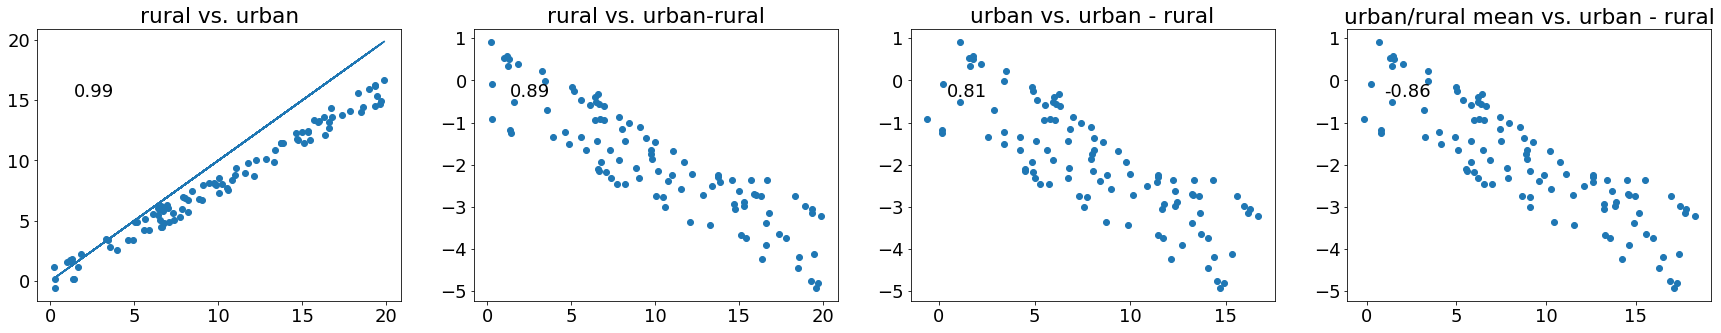

In [128]:
# a = rural 
# b = urban
a= np.random.rand(100,1)*20
b = a*.8 + (np.random.rand(100,1)-.5)*2

plt.figure(figsize = [30,5])
plt.subplot(141)
plt.scatter(a,b)
plt.plot(a,a)
plt.title('rural vs. urban')
plt.annotate('%2.2f'%scipy.stats.pearsonr(a,b)[0][0], xy = (0.1, .75), xycoords='axes fraction', )

plt.subplot(142)
plt.scatter(a,b-a)
plt.title('rural vs. urban-rural')
plt.annotate('%2.2f'%scipy.stats.pearsonr(a,a-b)[0][0], xy = (0.1, .75), xycoords='axes fraction', )

plt.subplot(143)
plt.scatter(b,b-a)
plt.title('urban vs. urban - rural')
plt.annotate('%2.2f'%scipy.stats.pearsonr(b,a-b)[0][0], xy = (0.1, .75), xycoords='axes fraction', )

plt.subplot(144)
plt.scatter((a+b)*.5,b-a)
plt.title('urban/rural mean vs. urban - rural')
plt.annotate('%2.2f'%scipy.stats.pearsonr((a+b)*.5,b-a)[0][0], xy = (0.1, .75), xycoords='axes fraction', )

In [151]:
a,b

(month_period
 1985-06-01    16.7
 1985-06-02    18.3
 1985-06-03    17.2
 1985-06-04    17.2
 1985-06-05    16.1
 1985-06-06    16.1
 1985-06-07    10.6
 1985-06-08    16.7
 1985-06-09    16.1
 1985-06-10    18.3
 1985-06-11    17.8
 1985-06-12    17.8
 1985-06-13    10.6
 1985-06-14     8.3
 1985-06-15    11.7
 1985-06-16    16.1
 1985-06-17    15.0
 1985-06-18    18.3
 1985-06-19    17.2
 1985-06-20    13.3
 1985-06-21    11.1
 1985-06-22    13.9
 1985-06-23    18.3
 1985-06-24    18.9
 1985-06-25    13.3
 1985-06-26    14.4
 1985-06-27    13.3
 1985-06-28    12.2
 1985-06-29    13.9
 1985-06-30    16.1
               ... 
 2016-08-02    21.1
 2016-08-03    18.3
 2016-08-04    17.2
 2016-08-05    17.8
 2016-08-06    20.0
 2016-08-07    18.3
 2016-08-08    19.4
 2016-08-09    18.9
 2016-08-10    19.4
 2016-08-11    19.4
 2016-08-12    23.9
 2016-08-13    25.0
 2016-08-14    24.4
 2016-08-15    22.8
 2016-08-16    22.2
 2016-08-17    22.2
 2016-08-18    22.2
 2016-08-19    20.6
 2016-

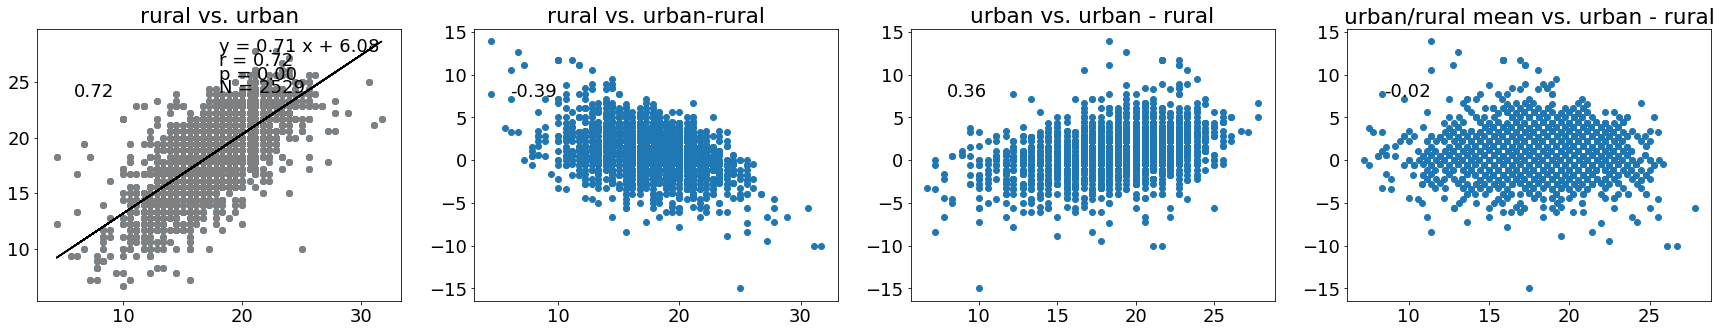

In [152]:
# now with data 
# a = rural 
# b = urban
a = rural_summer[UHI.index]
b = urban_summer[UHI.index]
a = a[~np.isnan(a) & ~np.isnan(b)]
b = b[~np.isnan(a) & ~np.isnan(b)].values

plt.figure(figsize = [30,5])
plt.subplot(141)
plt.scatter(a,b)
#plt.plot(a,a)
hw_scatter(a.values,b, '', '', '')
plt.title('rural vs. urban')
plt.annotate('%2.2f'%scipy.stats.pearsonr(a,b)[0], xy = (0.1, .75), xycoords='axes fraction', )

plt.subplot(142)
plt.scatter(a,b-a)
plt.title('rural vs. urban-rural')
plt.annotate('%2.2f'%scipy.stats.pearsonr(a,b-a)[0], xy = (0.1, .75), xycoords='axes fraction', )

plt.subplot(143)
plt.scatter(b,b-a)
plt.title('urban vs. urban - rural')
plt.annotate('%2.2f'%scipy.stats.pearsonr(b,b-a)[0], xy = (0.1, .75), xycoords='axes fraction', )

plt.subplot(144)
plt.scatter((a+b)*.5,b-a)
plt.title('urban/rural mean vs. urban - rural')
plt.annotate('%2.2f'%scipy.stats.pearsonr((a+b)*.5,b-a)[0], xy = (0.1, .75), xycoords='axes fraction', )

In [ ]:
# # plots a map and histogram of data, a pandas dataframe with cities in the index 
# # paired_df 
# import matplotlib.ticker as ticker
# import string
# def inset_scatter(x,y,title, xlabel, ylabel) : 
# # plots x,y (need to be np array) and calculates and prints their best fit line
#     ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
#     m,b = np.polyfit(x[ind],y[ind],1)
#     r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
#     plt.scatter(x,y, color = 'grey', alpha = .5)
#     plt.plot(x, m*x+b, color = 'black')
#     plt.title(title)
#     plt.ylabel(ylabel)
#     plt.xlabel(xlabel)
#     # annotate the linear reqression, y = mx+b
#     plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.1, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
# #     plt.annotate('r = %.2f'%(r), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
# #     plt.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
# #     plt.annotate('N = %i'%(ind.shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
#     return m, r, p

# fig = plt.figure(figsize=[18,7])
# ax = plt.axes([0, 0, 1, 1],
#                    projection=ccrs.LambertConformal())
# ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
# #ax.set_title(title)
# # download default shapefils from natura_earth using cartopy's shapereader
# shapename = 'admin_1_states_provinces_lakes_shp'
# states_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)

# # to get the effect of having just the states without a map "background"
# # turn off the outline and background patches
# ax.background_patch.set_visible(False)
# ax.outline_patch.set_visible(False)

# # Plot background state map
# for state in shpreader.Reader(states_shp).geometries():
#     # pick a default color for the land with a black outline,
#     # this will change if the storm intersects with our track
#     facecolor = 'None'#[0.9375, 0.9375, 0.859375]
#     edgecolor = 'black'
#     ax.add_geometries([state], ccrs.PlateCarree(),
#                       facecolor=facecolor, edgecolor=edgecolor, zorder = 0)

# # define data
# data = results_df.drop(drop_cities, axis = 0)['Slope']
# data = data[~np.isnan(data)]
# # Set up colors for plotting
# cmap = matplotlib.cm.coolwarm
# c = data
# bounds = np.linspace(-1,1,11)
# norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
# marker_size = 150

# # plot data
# plotHandle = ax.scatter(paired_df.set_index('City').loc[c.index]['Urban Lon'], paired_df.set_index('City').loc[c.index]['Urban Lat'], 
#                         c = c.values, s = marker_size, alpha = 1, 
#                         transform=ccrs.Geodetic(), edgecolors = 'darkgray', 
#                  cmap = cmap,
#                  norm = norm, zorder = 1, )
# plt.title('d)')

# ##### Histogram 
# sub_ax = plt.axes([0.05, 0.0, 0.2, 0.3])

# #plot data
# n, bins, patches = sub_ax.hist(data,10, facecolor = 'darkgray', linewidth=0)
# # annotate and label 
# sub_ax.annotate('$ \mu = %2.2f $'%data.mean(), xy=(1.0, .4), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
# sub_ax.annotate('$ \sigma  = %2.2f $'%data.std(), xy=(1.0, .25), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
# sub_ax.annotate('range = $%2.2f, %2.2f $'%(data.min(), data.max()), xy=(1.0, .1), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
# sub_ax.set_xlabel('$m$ ($^\circ$ C/ $^\circ$ C)')#data_label) #'m$_{JJA}$ ($^\circ$C$ / ^\circ $C)')
# sub_ax.set_ylabel('Count')
# sub_ax.set_title('c) Histogram')

# # set colors 
# m = matplotlib.cm.ScalarMappable(norm = norm, cmap = cmap)
# m._A = []

# bin_centers = 0.5 * (bins[:-1] + bins[1:])
# for c,p in zip(bin_centers, patches): # in range(np.size(patches)):
#     plt.setp(p,'facecolor', m.to_rgba(c))#color=m.to_rgba(c))
# #plt.colorbar(m)

# # plot  city data 
# # sub_ax2 = plt.axes([0.75, 0.75, 0.1, 0.2])
# # sub_ax3 = plt.axes([0.75, 0.35, 0.1, 0.2])
# dummy_ind = 0
# for i in [22, 26]: 
#     city = paired_df.loc[i]['City']
#     city = unicode(city, errors = 'ignore')
#     urbanID = paired_df.loc[i]['Urban station']
#     ruralID = paired_df.loc[i]['Rural station']
#     print city
#     # Downloadd from NCDC the station data, using the station ID listed in station list
#     urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
#                                          as_dataframe=True, update = False)
#     ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
#                                          as_dataframe=True, update = False)
#     ######
#     ###### Import data
#     ######
#     rural_tmin = pd.to_numeric(ruraldata['TMIN']['1985-01-01':].value/10.) #rural tmin
#     urban_tmin = pd.to_numeric(urbandata['TMIN']['1985-01-01':].value/10.)         
#     # extract summertime data 
#     rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
#     urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]
#     # clean data: eliminate min temperatures below 4 or above 35
#     rural_summer = rural_summer[(rural_summer>4) & (rural_summer<35)]
#     urban_summer = urban_summer[(urban_summer>4) & (urban_summer < 35)]

#     #calculate UHI
#     UHI = urban_summer - rural_summer
    
#     if dummy_ind ==0 : 
#         sub_ax3 = plt.axes([0.9, 0.0, 0.25, 0.35])
#         inset_scatter(rural_summer[UHI.index], UHI,'b) %s'%(city),
#                   '$T_r$ ($^\circ$ C)', '$\Delta T$ ($^\circ$ C)') 
#     else: 
#         sub_ax2 = plt.axes([0.9, 0.6, 0.25, 0.35])
#         inset_scatter(rural_summer[UHI.index], UHI,'a) %s'%(city),
#                   '$T_r$ ($^\circ$ C)', '$\Delta T$ ($^\circ$ C)') 


#     ##### Inset plot     
    
#     dummy_ind = dummy_ind+1
    
# sub_ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
# sub_ax2.yaxis.set_major_locator(ticker.MultipleLocator(5))
# sub_ax3.xaxis.set_major_locator(ticker.MultipleLocator(10))
# sub_ax3.yaxis.set_major_locator(ticker.MultipleLocator(5))

# prettify_plot()
# #return fig 

# plt.savefig(results_filepath+ 'fullJJAslopes.pdf', bbox_inches='tight')

In [26]:
# load error bars
results_filepath_error_bars = 'plots/version2/UHIvariance/' 
cities = paired_df['City'].values
UHI_std = []
for i in range(0,paired_df.shape[0]): # probalby need to redo 1-15
    city = paired_df.iloc[i]['City']
    if city == 'Grand Prairie': 
        city = 'Arlington'
    try: 
        array = np.load(results_filepath_error_bars+'UHIs/'+ city.replace(" ", "")[0:5]+'UHI.npy')
        array = array[~np.isnan(array)]
        UHI_std.append(array.std())
    except IOError: 
        print('Skipping %s'%city)
        
# drop #2- it's a duplicate
#del UHI_std[1]

In [27]:
len(UHI_std)

53

1.11051397143e-05


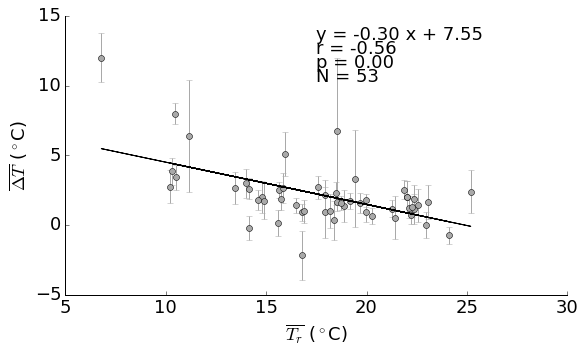

In [46]:
# hw_scatter(results_df['Mean JJA Rural Temp'],results_df['Mean UHI'],
#              'Do hotter cities have higher $\Delta T$?', 
#              '$T_r$ ($^\circ$C)', '$\overline{\Delta T}$ ($\Delta ^\circ$C)')
plt.figure(figsize=[9,5])
x = results_df['Mean JJA Rural Temp']
y = results_df['Mean UHI']
plt.errorbar(x, y, yerr = UHI_std, fmt='o', color = 'DarkGray')
m,r,p = hw_scatter(x,y,
             '', 
             '$\overline{T_r}$ ($^\circ$C)', '$\overline{\Delta T}$ ($^\circ$C)')
prettify_plot()
plt.savefig(results_filepath+ 'meantempvsmeanUHI.pdf',bbox_inches='tight')
print(p)

In [51]:
results_df['hw Correlation'].describe()

count    52.000000
mean     -0.372430
std       0.216515
min      -0.834371
25%      -0.522048
50%      -0.365787
75%      -0.232947
max       0.130977
Name: hw Correlation, dtype: float64

#### results_df[results_df['hw P-value']<0.05]['hw Slope'].describe()

In [33]:
results_df.drop(drop_cities, axis = 0)['hw Slope'].describe()

count    53.000000
mean     -0.931084
std       0.625705
min      -2.098968
25%      -1.310920
50%      -0.992990
75%      -0.571744
max       0.680402
Name: hw Slope, dtype: float64

In [120]:
# Heatwave map
# note: c_insignificant = results_df[results_df['hw P-value']>0.05] but this data seems to not be saved? check older versions of file
drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
data = results_df['hw Slope']#.drop(drop_cities) #slopes

fig, ax, sub_ax = map_hist_plot(data, paired_df, title = 'Average Heatwaves',# ''$\Delta T$ sensitivity to average heatwaves temp. change', 
                    data_label='m$_{hw}$ ($^\circ$C/$^\circ$C)', 
                   c_insignificant = results_df[results_df['hw P-value']>0.05]) 
ax.set_title('e)')
sub_ax.set_title('f)')
plt.savefig(results_filepath+ 'avghwslopemap.pdf', bbox_inches='tight')

KeyError: 'hw Slope'

In [541]:
mean_summer_tvsdt.columns

Index([u'Unnamed: 0', u'm', u'r', u'p-value'], dtype='object')

In [452]:
mean_summer_tvsdt.loc['Washington, D.C.']

Unnamed: 0    57.000000
m             -0.283249
r             -0.168241
p-value        0.365621
Name: Washington, D.C., dtype: float64

In [451]:
mean_summer_tvsdt.loc['Baltimore']

Unnamed: 0    25.000000
m             -0.508793
r             -0.587960
p-value        0.000634
Name: Baltimore, dtype: float64

In [287]:
# change over time: summer annual temps
mean_summer_tvsdt = pd.read_csv('plots/version2/'+'summermeans/'+'mean_summer_tvsdt_results.csv').drop(2).set_index(paired_df.City)

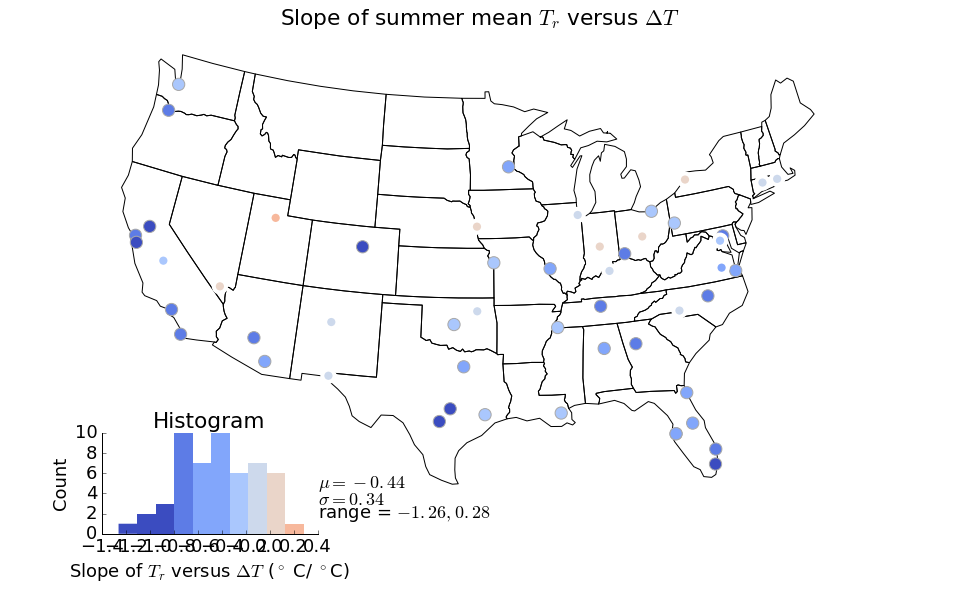

In [288]:
# change over time: summer annual temps versus UHI
mean_summer_tvsdt = pd.read_csv('plots/version2/'+'summermeans/'+'mean_summer_tvsdt_results.csv').drop(2).set_index(paired_df.City)
drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
data = mean_summer_tvsdt.drop(drop_cities)['m']
fig = map_hist_plot(data, paired_df, title = 'Slope of summer mean $T_r$ versus $\Delta T$', 
                    data_label='Slope of $T_r$ versus $\Delta T$ ($^\circ$ C/ $^\circ $C)', 
                  c_insignificant = mean_summer_tvsdt[mean_summer_tvsdt['p-value']>0.05]) 
plt.savefig(results_filepath+ 'mean_summer_tvsdt_map.pdf', bbox_inches='tight')

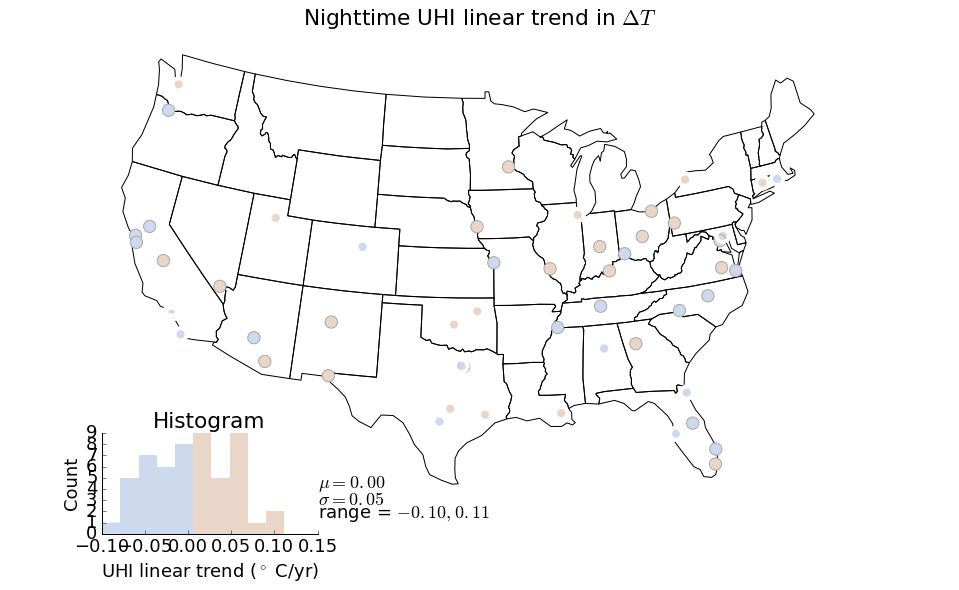

In [289]:
# linear trend in UHI
# check units- not sure if this is per year
drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
data = mean_summer_tvsdt.drop(drop_cities)['m']
data = results_df.drop(drop_cities)['UHI linear trend']

fig = map_hist_plot(data, paired_df, title = 'Nighttime UHI linear trend in $\Delta T$', 
                    data_label='UHI linear trend ($^\circ$ C/yr)', 
                  c_insignificant = results_df[results_df['UHI linear trend p-value']>0.05]) 
plt.savefig(results_filepath+ 'UHIlineartrend.pdf', bbox_inches='tight')

In [65]:
results_df.drop(drop_cities)['UHI linear trend'].mean()

0.004346023919132114

In [102]:
# percentage of warming cities
print((results_df.drop(drop_cities)['UHI linear trend'] > 0).sum()/ float(results_df.drop(drop_cities).shape[0]))
print((results_df.drop(drop_cities)['UHI linear trend'] > 0).sum())

0.528301886792
28


In [104]:
# percentage of cooling cities
print((results_df.drop(drop_cities)['UHI linear trend'] < 0).sum()/ float(results_df.drop(drop_cities).shape[0]))
print((results_df.drop(drop_cities)['UHI linear trend'] < 0).sum())

0.471698113208
25


In [53]:
results_filepath

'plots/version3/'

In [50]:
trend_resultDF = pd.read_csv(results_filepath+'30yrtrend/trend_results.csv').drop(2).set_index(pairs.drop(2)['City']).drop(drop_cities)

In [51]:
# load error bars
results_filepath_error_bars = 'plots/version2/UHIvariance/' 
cities = paired_df['City'].values
slopes_std = []
for i in range(0,paired_df.shape[0]): # probalby need to redo 1-15
    city = paired_df.iloc[i]['City']
    if city == 'Grand Prairie': 
        city = 'Arlington'
    try: 
        array = np.load(results_filepath_error_bars+'slopes/'+ city.replace(" ", "")[0:5]+'m.npy')
        array = array[~np.isnan(array)]
        slopes_std.append(array.std())
    except IOError: 
        print('Skipping %s'%city)
        
# resize: 1 & 2 are the same
#slopes_std
# drop #2- it's a duplicate
#del slopes_std[1]

In [52]:
trend_resultDF['Annual UHI Slope'].mean()

0.004346023919132114

In [48]:
x.shape, y.shape, len(slopes_std)

((53,), (53,), 53)

3.95573305242e-09


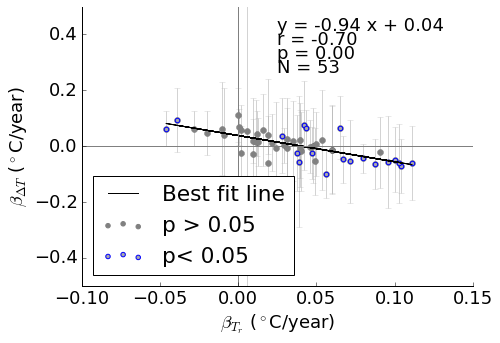

In [75]:
x = trend_resultDF['Annual Temp Slope']
y =  trend_resultDF['Annual UHI Slope']
plt.figure(figsize=[7,5])
plt.errorbar(x, y, yerr = slopes_std, fmt='o', alpha = .5,#markersize='10', 
             color = 'DarkGray', zorder =0)

m, r, p = hw_scatter(trend_resultDF['Annual Temp Slope'], trend_resultDF['Annual UHI Slope'],
           '', r'$\beta_{T_r}$ ($^\circ$C/year)', #30-year JJA Trend Relationship
           r'$\beta_{\Delta T}$ ($^\circ$C/year)')

plt.scatter(trend_resultDF[(trend_resultDF['Temp p-value'] < .05) & (trend_resultDF['UHI p-value']<.05)]['Annual Temp Slope'], 
           trend_resultDF[(trend_resultDF['Temp p-value'] < .05) & (trend_resultDF['UHI p-value']<.05)]['Annual UHI Slope'], 
           color = 'darkgray', edgecolor = 'blue', zorder =1)

plt.legend(['Best fit line', 'p > 0.05', 'p< 0.05'], loc = 3)

plt.axhline(0, color = 'gray')
plt.axvline(0, color = 'gray')
plt.ylim([-0.5,.5])
prettify_plot()
plt.savefig(results_filepath+'30yeartrend.pdf', bbox_inches='tight')
print(p)x = trend_resultDF['Annual Temp Slope']
y =  trend_resultDF['Annual UHI Slope']
plt.figure(figsize=[7,5])
plt.errorbar(x, y, yerr = slopes_std, fmt='o', alpha = .5,#markersize='10', 
             color = 'DarkGray', zorder =0)

m, r, p = hw_scatter(trend_resultDF['Annual Temp Slope'], trend_resultDF['Annual UHI Slope'],
           '', r'$\beta_{T_r}$ ($^\circ$C/year)', #30-year JJA Trend Relationship
           r'$\beta_{\Delta T}$ ($^\circ$C/year)')

plt.scatter(trend_resultDF[(trend_resultDF['Temp p-value'] < .05) & (trend_resultDF['UHI p-value']<.05)]['Annual Temp Slope'], 
           trend_resultDF[(trend_resultDF['Temp p-value'] < .05) & (trend_resultDF['UHI p-value']<.05)]['Annual UHI Slope'], 
           color = 'darkgray', edgecolor = 'blue', zorder =1)

plt.legend(['Best fit line', 'p > 0.05', 'p< 0.05'], loc = 3)

plt.axhline(0, color = 'gray')
plt.axvline(0, color = 'gray')
plt.ylim([-0.5,.5])
prettify_plot()
plt.savefig(results_filepath+'30yeartrend.pdf', bbox_inches='tight')
print(p)

In [198]:
trend_resultDF['Annual Temp Slope'].describe()

count    53.000000
mean      0.035613
std       0.036743
min      -0.046287
25%       0.011031
50%       0.037478
75%       0.056343
max       0.111238
Name: Annual Temp Slope, dtype: float64

In [225]:
results_df.columns

Index([u'Unnamed: 0', u'Slope', u'Intercepts', u'Residual', u'Correlation',
       u'P-value', u'Urban start date', u'Urban end date', u'Rural start date',
       u'Rural end date', u'Data points', u'Mean UHI', u'Day of Max UHI',
       u'Mean JJA Rural Temp', u'UHI linear trend',
       u'UHI linear trend p-value', u'hw Slope', u'hw P-value', u'hw Residual',
       u'hw Correlation', u'hw Data points', u'hw Mean UHI',
       u'hw Mean JJA Rural Temp'],
      dtype='object')

In [226]:
pd.read_csv('plots/version3/30yrtrend/trend_results.csv')['Annual UHI Slope'].describe()

count    59.000000
mean      0.000315
std       0.053060
min      -0.169198
25%      -0.035527
50%       0.000644
75%       0.041855
max       0.111211
Name: Annual UHI Slope, dtype: float64

In [199]:
trend_resultDF['Annual UHI Slope'].describe()

count    53.000000
mean      0.004346
std       0.048908
min      -0.099377
25%      -0.027453
50%       0.002383
75%       0.044496
max       0.111211
Name: Annual UHI Slope, dtype: float64

In [213]:
trend_resultDF[(trend_resultDF['Temp p-value'] < .05) & (trend_resultDF['UHI p-value']<.05)].shape

(19, 11)

In [205]:
results_df.columns

Index([u'Unnamed: 0', u'Slope', u'Intercepts', u'Residual', u'Correlation',
       u'P-value', u'Urban start date', u'Urban end date', u'Rural start date',
       u'Rural end date', u'Data points', u'Mean UHI', u'Day of Max UHI',
       u'Mean JJA Rural Temp', u'UHI linear trend',
       u'UHI linear trend p-value', u'hw Slope', u'hw P-value', u'hw Residual',
       u'hw Correlation', u'hw Data points', u'hw Mean UHI',
       u'hw Mean JJA Rural Temp'],
      dtype='object')

In [207]:
results_df.drop(drop_cities)['UHI linear trend'].describe()

count    53.000000
mean      0.004346
std       0.048908
min      -0.099377
25%      -0.027453
50%       0.002383
75%       0.044496
max       0.111211
Name: UHI linear trend, dtype: float64

In [197]:
# number of cities experiencing warming
print((trend_resultDF['Annual Temp Slope']>0).sum(), ' out of ', trend_resultDF.shape[0])
print('or ',  100*(trend_resultDF['Annual Temp Slope']>0).sum()/ float(trend_resultDF.shape[0]), ' percent')

(46, ' out of ', 53)
('or ', 86.79245283018868, ' percent')


In [215]:
(trend_resultDF[trend_resultDF['Annual Temp Slope']>0]['Annual UHI Slope'] < 0).sum()

25

In [216]:
## cooling cities
(trend_resultDF['Annual Temp Slope']<0).sum()

7

In [210]:
print((trend_resultDF[trend_resultDF['Annual Temp Slope']<0]['Annual UHI Slope'] > 0).sum())

7


In [211]:
# number of points which don't fit the story: warming but UHI increasing
(trend_resultDF[trend_resultDF['Annual Temp Slope']>0]['Annual UHI Slope'] > 0).sum()

21

In [212]:
# how many of the insignificant cities are ones in which our story doesn't fit? 
insig_index = trend_resultDF[(trend_resultDF['Temp p-value'] < .05) & (trend_resultDF['UHI p-value']<.05)].index
not_fit_index = (trend_resultDF[trend_resultDF['Annual Temp Slope']>0]['Annual UHI Slope'] > 0).index
np.intersect1d(insig_index, not_fit_index).shape

(17,)

In [217]:
# how many cooling cities have increased UHI
(trend_resultDF[trend_resultDF['Annual Temp Slope']<0]['Annual UHI Slope'] > 0).sum()

7

In [330]:
trend_resultDF['Annual Temp Slope'].describe()

count    58.000000
mean      0.036885
std       0.041853
min      -0.047103
25%       0.006567
50%       0.033759
75%       0.059268
max       0.134933
Name: Annual Temp Slope, dtype: float64

In [331]:
trend_resultDF['Annual UHI Slope'].describe()

count    58.000000
mean      0.000152
std       0.053657
min      -0.168602
25%      -0.039665
50%       0.000293
75%       0.042268
max       0.108919
Name: Annual UHI Slope, dtype: float64

In [46]:
cols.shape

(11,)

In [80]:
cols = np.arange(-5,6)
drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
composite_cities = pd.read_csv(results_filepath + results_filename)['City']

compositeTempDF = pd.read_csv((results_filepath + 'composite_temp.csv'), header = None, names =  cols).set_index(composite_cities).loc[results_df.index]#.drop(drop_cities, axis = 0)
compositeUHIDF = pd.read_csv((results_filepath + 'composite_UHI.csv'), header = None, names =  cols).set_index(composite_cities).loc[results_df.index]#.drop(drop_cities, axis = 0)

In [138]:
results_filepath

'plots/version3/'

In [82]:
compositeTempDF.shape, compositeUHIDF.shape

((53, 11), (53, 11))

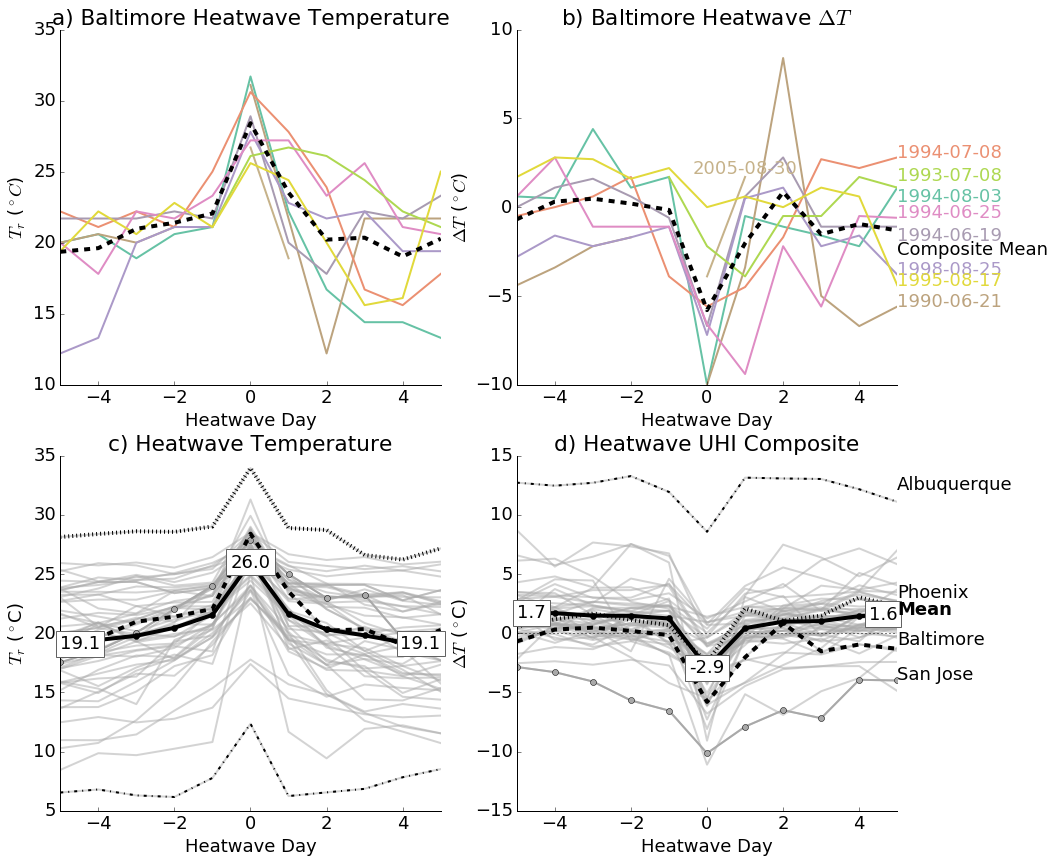

In [88]:
plt.figure(figsize=[15,14])
from cycler import cycler
plt.rc('axes', prop_cycle=(cycler('color', plt.cm.Set2(np.linspace(0.0,0.75,10)))))
bmorec = 'k'
plt.subplot(2,2,1)
tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, linewidth = 2)
plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), '--', 
         color = bmorec, 
         linewidth = 4, )
plt.title('a) %s Heatwave Temperature'%(city))
plt.ylabel('$T_r$ ($^\circ C$)')
plt.xlabel('Heatwave Day')
plt.xlim([-5,5])
#plt.legend(legend_str,loc = 2)
prettify_plot()

plt.subplot(2,2,2)    
uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, linewidth = 2)
plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0),
         '--',color = bmorec, linewidth = 4, label = 'Composite Mean Event'),#color = 'black',)

plt.title('b) %s Heatwave $\Delta T$'%(city))
plt.ylabel('$\Delta T $ ($ ^\circ C$)')
plt.xlabel('Heatwave Day')
plt.xlim([-5,5])
prettify_plot()
i = 0
for date in heatwaves.index: 
    if ~np.isnan(compositeUHI[i][10]): 
        if i ==0 : 
            plt.text(5, compositeUHI[i][10]-.8, date, color = tHandle[i].get_color()) # 1994-08-03
        elif i ==3: 
            plt.text(5, compositeUHI[i][10]-.8, date, color = tHandle[i].get_color())#, color = plt.cm.viridis(i)) 1993-07-08
        elif i ==7: 
            plt.text(5, compositeUHI[i][10]+.4, date, color = tHandle[i].get_color())# 1993-07-08
        else: 
            plt.text(5, compositeUHI[i][10], date, color = tHandle[i].get_color())#, verticalalignment='center', horizontalalignment='left')#, color = plt.cm.viridis(i))
    else: 
        plt.text(1, compositeUHI[i][6]+1, date, verticalalignment='top', horizontalalignment='center', color = tHandle[i].get_color())#, color = 'red')#plt.cm.viridis(i))

    i = i+1
plt.text(5,np.nanmean(compositeUHI, axis=0)[9]-1.7, 'Composite Mean', color = 'black')

x = np.arange(-5,6)
# plot heatwave composites for all stations
#plt.figure(figsize = [15,5])
#plot temperature,raw
plt.subplot(2,2,3)
for i in range(0, compositeTempDF.shape[0]) : 
    #print compositeUHIDF2.iloc[i].values[1:]
    plt.plot(x, compositeTempDF.iloc[i].values[0:], color = 'DarkGray', zorder = 0, alpha = .5, linewidth = 2)#, '-o')

#plt.errorbar(x,compositeTempDF.mean(), yerr=compositeTempDF.std(), color = 'k', zorder = 1)
#compositeTempDF.mean(axis=0).plot(yerr = compositeTempDF.std(axis=0))
plt.plot(x, compositeTempDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, label = 'Baltimore')
plt.plot(x, compositeTempDF.loc['Phoenix'], ':', color = 'k', alpha = 1, linewidth = 4, label = 'Phoenix')
plt.plot(x, compositeTempDF.loc['Albuquerque'], '-.', color = 'k', alpha = 1, linewidth = 2, label = 'Albuquerque')
plt.plot(x, compositeTempDF.loc['San Jose'], '-o', color = 'DarkGray', zorder = 0, alpha = 1, linewidth = 2, label = 'San Jose')

plt.plot( x, compositeTempDF.mean(), '-o', color = 'k', linewidth = 4)
plt.xlabel('Heatwave Day')
plt.ylabel('$T_r$ ($^\circ$C)')
plt.title('c) Heatwave Temperature')
plt.xlim([-5,5])
xx = -5
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='left')

xx = 0
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'), 
         verticalalignment='center', horizontalalignment='center'
                 )
xx = 5
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='right')

# plt.text(2,compositeTempDF.loc[compositeTempDF.mean(axis=1).argmin()][4],'%s'%compositeTempDF.mean(axis=1).argmin())
# plt.text(2,compositeTempDF.loc[compositeTempDF.mean(axis=1).argmax()][4],'%s'%compositeTempDF.mean(axis=1).argmax())
# plt.text(2,compositeTempDF.loc['Baltimore'][4],'Baltimore', color = bmorec, zorder = 0)
prettify_plot()

#plot UHI, raw
plt.subplot(2,2,4)

for i in range(0, compositeUHIDF.shape[0]) : 
    #print compositeUHIDF2.iloc[i].values[1:]
    plt.plot(x, compositeUHIDF.iloc[i].values[0:], color = 'DarkGray', zorder = 0, alpha = .5, linewidth = 2)#, '-o')
plt.plot( x, compositeUHIDF.mean(), '-o', color = 'k', linewidth = 4,)
#plt.errorbar(x,compositeUHIDF.mean(), yerr=compositeUHIDF.std(), color = 'k', zorder = 1)
plt.axhline(0, linestyle = ':', color = 'k')

plt.xlabel('Heatwave Day')
plt.xlim([-5,5])
plt.ylabel('$\Delta T$ ($^\circ$C)')
plt.title('d) Heatwave UHI Composite')
prettify_plot()

xx = -5
yy = compositeUHIDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='left')

xx = 0
yy = compositeUHIDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'), 
         verticalalignment='center', horizontalalignment='center'
                 )
xx = 5
yy = compositeUHIDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='right')

plt.text(5,compositeUHIDF.loc[compositeUHIDF.mean(axis=1).argmin()][4],'%s'%compositeUHIDF.mean(axis=1).argmin())
plt.text(5,compositeUHIDF.loc[compositeUHIDF.mean(axis=1).argmax()][4],'%s'%compositeUHIDF.mean(axis=1).argmax())
plt.text(5,compositeUHIDF.loc['Baltimore'][4],'Baltimore', color = bmorec)
plt.text(5,compositeUHIDF.loc['Phoenix'][4],'Phoenix', color = 'k')
plt.text(5, compositeUHIDF.mean()[5], 'Mean', color = 'k', weight = 'bold')

plt.plot(x, compositeUHIDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, label = 'Baltimore')
plt.plot(x, compositeUHIDF.loc['Albuquerque'], '-.', color = 'k', alpha = 1, linewidth = 2, label = 'Albuquerque')
plt.plot(x, compositeUHIDF.loc['San Jose'], '-o', color = 'DarkGray', zorder = 0, alpha = 1, linewidth = 2, label = 'San Jose')
plt.plot(x, compositeUHIDF.loc['Phoenix'], ':', color = 'k', zorder = 0, alpha = 1, linewidth = 4, label = 'Phoenix')

#plt.legend(loc = 'center left', bbox_to_anchor=(1.0, 0.5))

plt.savefig(results_filepath+ 'hwcompositeTMIN.pdf',bbox_inches='tight')

In [159]:
# sufficient to reduce $\Delta T$ to below zero on heatwave day 0 in all but 10 cities (47/52)....
compositeUHIDF[0][compositeUHIDF[0] >0 ].shape

(9,)

In [160]:
compositeTempDF.shape

(53, 11)

In [161]:
paired_df.shape

(53, 14)

In [441]:
i

9

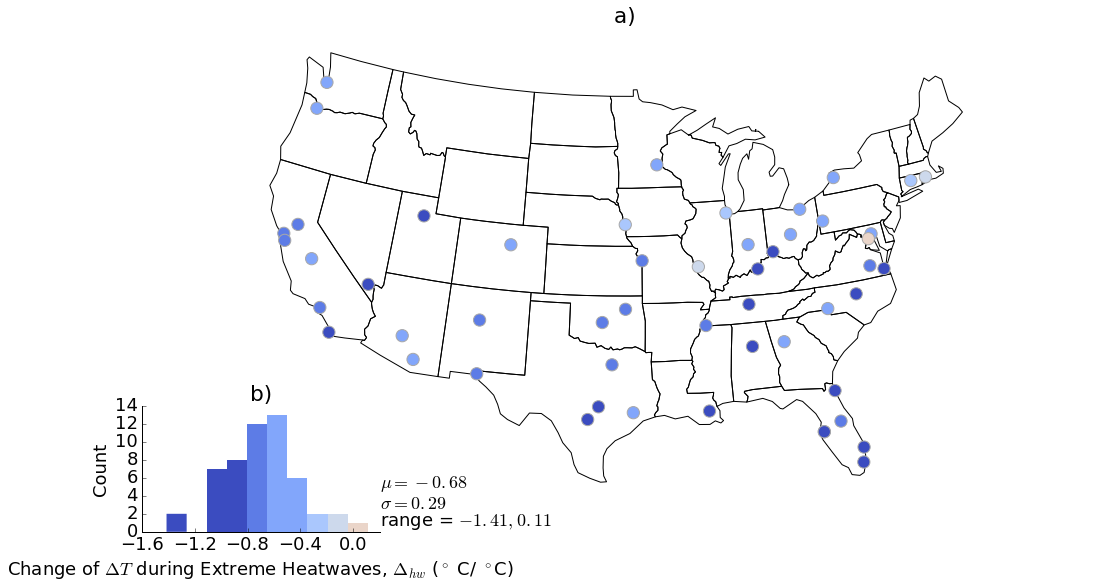

In [163]:
# extreme heatwave sensitivity map
drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
data = compositeUHIDF[0].subtract(compositeUHIDF[-5])/compositeTempDF[0].subtract(compositeTempDF[-5])#.drop(drop_cities)
fig, ax, sub_ax = map_hist_plot(data, paired_df, title = 'Extreme Heatwaves', 
                    data_label='Change of $\Delta T$ during Extreme Heatwaves, $\Delta_{hw}$ ($^\circ$ C/ $^\circ $C)', 
                ) 
sub_ax.set_xticks(sub_ax.get_xticks()[::2])
plt.savefig(results_filepath+ 'extreme_hw_map.pdf', bbox_inches='tight')

In [168]:
data = compositeUHIDF[0].subtract(compositeUHIDF[-5])/compositeTempDF[0].subtract(compositeTempDF[-5])

In [55]:
compositeTempDF.loc[compositeTempDF.mean(axis=1).argmin()][4]

7.8333333333333348

In [56]:
compositeTempDF.mean(axis=1).argmin()

'Albuquerque'

In [57]:
compositeTempDF.mean(axis=1).argmax()

'Phoenix'

In [58]:
compositeUHIDF.mean() - compositeUHIDF.mean()[-5]

-5    0.000000
-4   -0.044349
-3   -0.248405
-2   -0.272337
-1   -0.489324
 0   -4.659501
 1   -1.304766
 2   -0.762409
 3   -0.712969
 4   -0.298066
 5   -0.130592
dtype: float64

In [59]:
compositeTempDF.mean() - compositeTempDF.mean()[-5]

-5    0.000000
-4    0.305249
-3    0.663975
-2    1.336077
-1    2.429975
 0    6.873858
 1    2.501363
 2    1.199462
 3    0.694046
 4    0.110860
 5    0.009745
dtype: float64

In [60]:
(compositeUHIDF.mean() - compositeUHIDF.mean()[-5])[0] / (compositeTempDF.mean() - compositeTempDF.mean()[-5])[0]

-0.67785823015066893

In [61]:
-4.65/6.87

-0.6768558951965066

In [62]:
(compositeUHIDF[0]< 0).sum()

44

In [63]:
(compositeUHIDF[0]> 0).sum()

9

In [64]:
compositeUHIDF.shape

(53, 11)

In [ ]:
# Plot boxplots of slopes
drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
JJAresults = pd.read_csv('plots/version3/US_results_cleaned_data.csv').set_index('City').drop(drop_cities, axis=0)

#cities = paired_df['City'].values
cities = JJAresults.index.values
M_list = []
for city in cities: #i in range(0,cities.shape[0]): # probalby need to redo 1-15
    #city = paired_df.iloc[i]['City']
    if city == 'Grand Prairie': 
        city = 'Arlington'
    try: 
        array = np.load(results_filepath+'slopes/'+ city.replace(" ", "")[0:5]+'m.npy')
        array = array[~np.isnan(array)]
        M_list.append(array)
        #M_list.append(np.load(results_filepath+'slopes/'+ city.replace(" ", "")[0:5]+'m.npy'))
    except IOError: 
#        M_list.append(np.loadtxt(results_filepath+'slopes/'+ city.replace(" ", "")[0:5]+'m.npy'))
        print('Skipping %s'%city)

plt.figure(figsize=[20,10])
ax = plt.subplot(111) 
ax.boxplot(M_list, vert = True)
ax.hold('True')
#Now load the calculated results 
#JJAresults = pd.read_csv('US_results_cleaned_data.csv').set_index('City')
#set up fake x axis
X = np.arange(1, cities.shape[0]+1)
Y = JJAresults['Slope'].loc[cities]
ax.axhline(Y.mean(), color = 'lightgray', label = '$\overline{m}$, this study')
ax.axhline(0, color = 'black', )
ax.plot(X,Y, '*', color = 'black', markerSize = 10, label = 'This study $m$')
ax.set_xlabel('City')
ax.set_xticklabels(cities, rotation = 90)
ax.set_ylabel('$m_{day}$ ($^\circ$C/$^\circ$C)')
#ax.set_title('Slope of UHI response to Temperature')
plt.ylim([-1., .25])
plt.legend()
plt.savefig(results_filepath+'allcitiesm.pdf', bbox_inches='tight')

In [ ]:
# Plot boxplots of UHI trend range
#results_filepath = 'plots/version2/UHIvariance_brightness_thresh/'
cities = []
M_list = []
for city in combined_cities: 
    if city == 'Grand Prairie': 
        city = 'Arlington'
    try: 
        array = np.load(results_filepath+'30yrtrend/'+ city.replace(" ", "")[0:5]+'30yrUHIslopes.npy')
        #array = np.load(results_filepath+'UHIs/'+ city.replace(" ", "")[0:5]+'UHI.npy')
        array = array[~np.isnan(array)]
        M_list.append(array)
        if city =='Arlington': 
            cities.append('Grand Prairie')
        else: 
            cities.append(city)
    except IOError: 
        print('Skipping %s'%city)

plt.figure(figsize=[20,10])
ax = plt.subplot(111) 
ax.boxplot(M_list, vert = True)
ax.hold('True')

X= np.arange(1, len(cities)+1)
Y= mydf.set_index('City')['UHI linear trend'][cities]# mydf['Mean UHI'][cities]
ax.axhline(Y.mean(), color = 'lightgray', label = 'Mean this study')
ax.axhline(0, color = 'black', )
ax.plot( X, Y,'*',#'x', 
        color = 'black', markerSize = 10, label = 'This study')
#ax.axhline(Y.mean(), color = 'black')
ax.plot(X,  ccUHIdf.set_index('City').loc[combined_cities]['UHI trend'],'*',#'x', 
        color = 'green', markerSize = 10, label = 'CC data')
#ax.axhline(ccUHIdf.set_index('City').loc[combined_cities]['UHI trend'].mean(), color = 'green')

ax.set_xlabel('City')
ax.set_xticklabels(cities, rotation = 90)

#plt.legend()
ax.set_ylabel('Annual Trend in $\Delta T$ ($^\circ$C/yr)')
ax.set_title('Possible UHI long term trends')
plt.ylim([-0.9, 1.0])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc =1) #loc='upper left', 
                #bbox_to_anchor=(1.0,0.5))
plt.savefig(results_filepath+'allcitiesUHItrend.pdf', bbox_inches='tight')

In [270]:
np.random.random?

(-0.0042316828591843283, -0.061140634494670679, 0.17225254490476657)

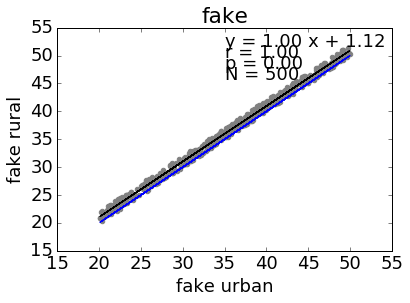

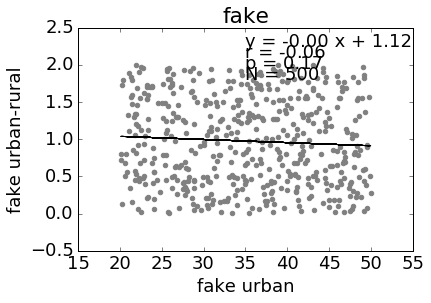

In [286]:
# mock up weather data
A = np.random.random(500)*30+20# dummy interval 20,50 
B = A + np.random.rand(500)*2
hw_scatter(A,B, 'fake','fake urban','fake rural')
plt.plot(A,A)
plt.figure()
hw_scatter(A,B-A, 'fake','fake urban','fake urban-rural')

In [301]:
R = np.zeros([100])
for i in range(0,55):
    A = np.random.random(500)*30+20# dummy interval 20,50 
    B = A + np.random.rand(500)*10
    R[i] = pearsonr_autocorrelated(A, B-A)[0]

In [307]:
R.max()

0.1257606757994808

(0.0012900545965588907, 0.0039907165924316897, 0.92907225785575231)

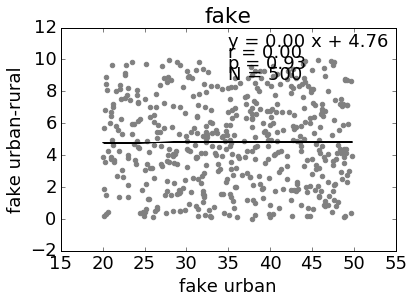

In [284]:
hw_scatter(A,B-A, 'fake','fake urban','fake urban-rural')

In [268]:
urban_summer[rural.shape, rural_summer.shape

((2944,), (2529,))

(0.7325647404610458, 0.72228588873171085, 0.0)

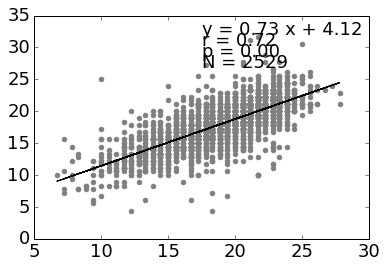

In [269]:
hw_scatter(urban_summer[rural_summer.index], rural_summer, '', '', '')

In [312]:
for i in range(0,15):
    A = np.random.random(500)*30+20# dummy interval 20,50 
    B = A + np.random.rand(500)*10
    print np.cov(A, B)[0,1]- np.var(A)

-0.794364808979
1.27407307141
1.27023330966
0.469485792603
1.15092908732
-0.0934555888362
-0.408964662477
0.811541105073
-1.49181492254
-2.01474224452
-0.0488208048767
-0.138572437994
-1.62269479058
0.952186640568
0.226804560496


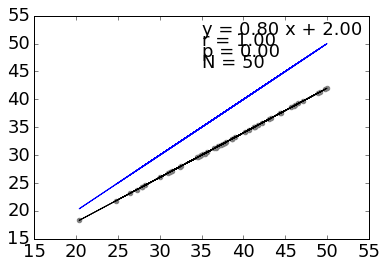

In [318]:
X = np.random.random(50)*30+20
b = 2
a = .8
hw_scatter(X, a*X+b, '', '', '')
plt.plot(X,X)